# Packages

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm
from PIL import Image
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import cv2
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from skimage.feature import graycomatrix, graycoprops
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0, VGG16, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 

c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project_loc\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Collection

## Data Loading

In [2]:
# path = kagglehub.dataset_download("prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed")

# print("Path to dataset files:", path)

In [2]:
DATA_PATH = "../data"

## Data Structure

In [4]:
# Chemin des images pour chaque classe
for dirname, subdirs, files in os.walk(DATA_PATH):
    print(f"\n Dossier : {dirname}")
    for filename in files[:5]:
        print("   -", filename)
    print("---"*25)


 Dossier : ../data
---------------------------------------------------------------------------

 Dossier : ../data\im_Dyskeratotic
---------------------------------------------------------------------------

 Dossier : ../data\im_Dyskeratotic\im_Dyskeratotic
   - 001.bmp
   - 001_cyt01.dat
   - 001_cyt02.dat
   - 001_cyt03.dat
   - 001_cyt04.dat
---------------------------------------------------------------------------

 Dossier : ../data\im_Dyskeratotic\im_Dyskeratotic\CROPPED
   - 001_01.bmp
   - 001_01_cyt.dat
   - 001_01_nuc.dat
   - 001_02.bmp
   - 001_02_cyt.dat
---------------------------------------------------------------------------

 Dossier : ../data\im_Koilocytotic
---------------------------------------------------------------------------

 Dossier : ../data\im_Koilocytotic\im_Koilocytotic
   - 001.bmp
   - 001_cyt01.dat
   - 001_nuc01.dat
   - 002.bmp
   - 002_cyt01.dat
---------------------------------------------------------------------------

 Dossier : ../data\im_K

In [5]:
# Classes
os.listdir(DATA_PATH)

['im_Dyskeratotic',
 'im_Koilocytotic',
 'im_Metaplastic',
 'im_Parabasal',
 'im_Superficial-Intermediate']

In [7]:
# Image format .bmp
classes = [d for d in os.listdir(DATA_PATH) if d.startswith("im_")]

all_images = []

# Calcul du nombre d'images par classe
for class_name in classes:
    # Dossier CROPPED contenant les images
    cropped_path = os.path.join(DATA_PATH, class_name, class_name, "CROPPED")
    if not os.path.exists(cropped_path):
        continue  

    # Récuopération de l'image dans le dossier CROPPED
    image_files = [f for f in os.listdir(cropped_path) if f.lower().endswith('.bmp')]
    
    for f in image_files:
        full_path = os.path.join(cropped_path, f)
        all_images.append((full_path, class_name))  # (chemin image, label)

    print(f"{class_name}: {len(image_files)} images")

print(f"\nNombre total d'images : {len(all_images)}")

im_Dyskeratotic: 813 images
im_Koilocytotic: 825 images
im_Metaplastic: 793 images
im_Parabasal: 787 images
im_Superficial-Intermediate: 831 images

Nombre total d'images : 4049


# Data Visualization

In [8]:
def display_images_from_folders(base_dir, categories, num_images=5):
    plt.figure(figsize=(15, 10))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(base_dir, category, category, "CROPPED")
        image_files = [f for f in os.listdir(category_path) if f.endswith(('.bmp', '.jpg', '.png'))]
        
        for j, image_file in enumerate(image_files[:num_images]):
    
            img_path = os.path.join(category_path, image_file)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(image)
            plt.axis('off')  
            plt.title(f"{category}") 

    plt.tight_layout()
    plt.show()

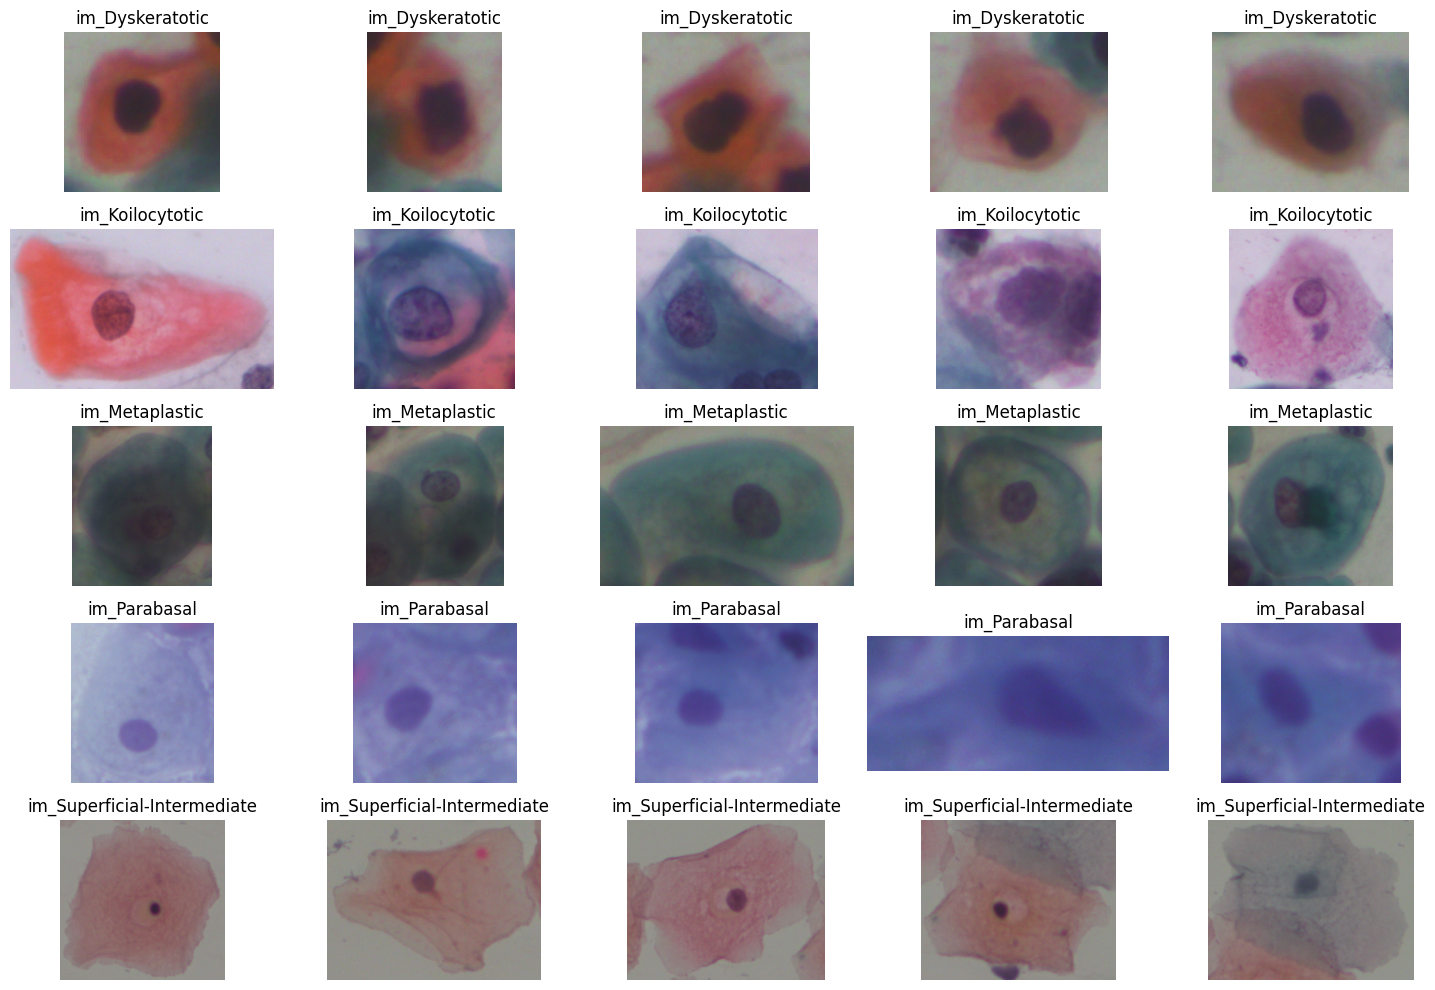

In [9]:
# Afficer 5 images dans chaque classe
display_images_from_folders(DATA_PATH, classes, num_images=5)

In [12]:
# Création d'un dataset à partir des images
data = pd.DataFrame(all_images, columns=["path", "label"])

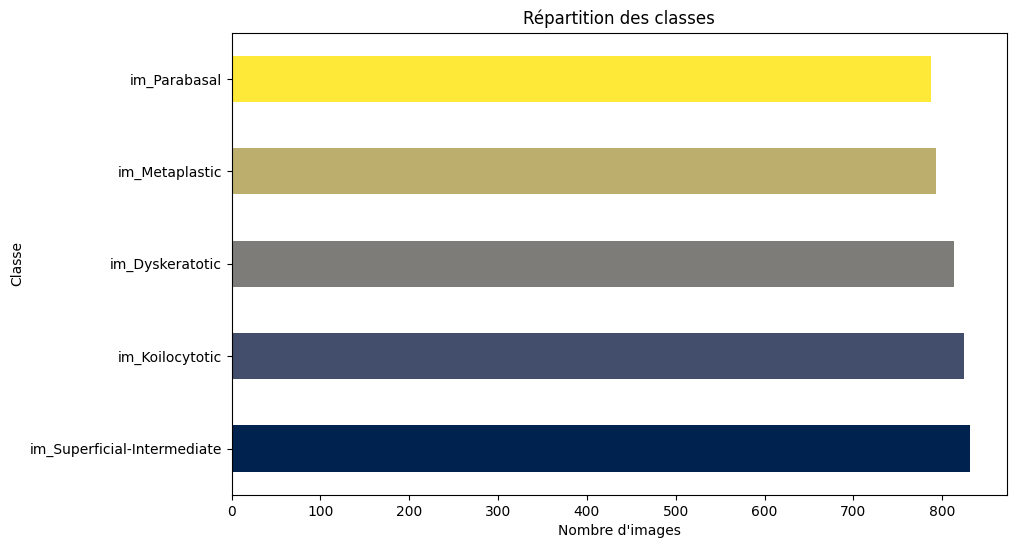

In [13]:
# Nombre de classes
class_counts = data['label'].value_counts()

colors = cm.cividis(np.linspace(0, 1, len(class_counts)))

plt.figure(figsize=(10, 6))
class_counts.plot(kind='barh', title='Répartition des classes', color=colors)
plt.xlabel('Nombre d\'images')
plt.ylabel('Classe')
plt.grid(False)
plt.show()

Les classes ne sont pas représentées dans une même proportion. La classe des cellules "superficial intermediate" est la plus représentée, suivie de la classe des cellules "superficial basal". Les autres classes sont moins représentées. Cependant, il n'y a pas un déséquilibre important entre les différentes classes de cellules.

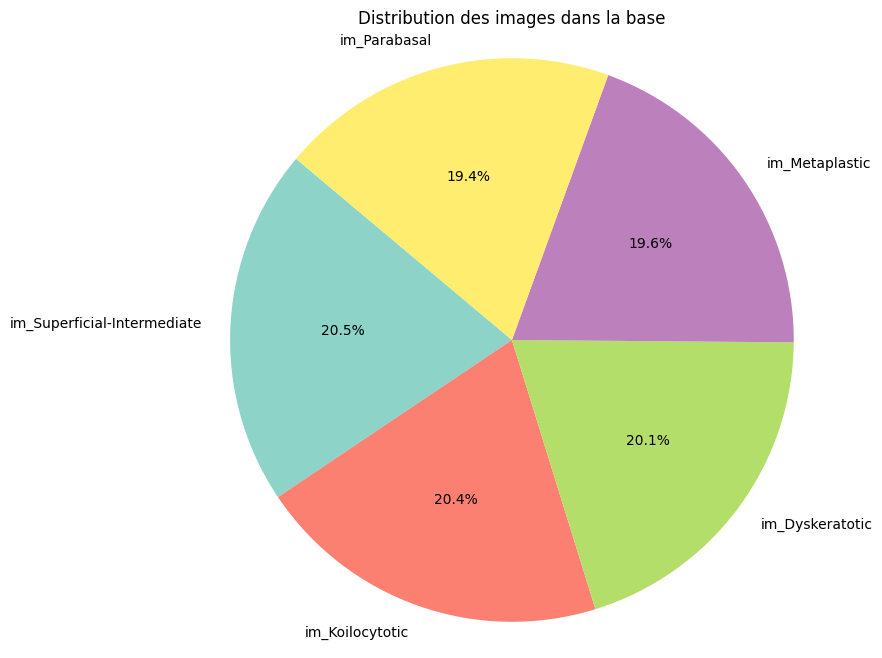

In [ ]:
# Part des classes dans le dataset
colors = cm.Set3(np.linspace(0, 1, len(class_counts)))

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution des images dans la base')
plt.axis('equal') 
plt.show()

# EDA

In [ ]:
# Changer l'écriture des chemins de manière à ce que ça soit conforme à comment 
# on accède aux fichiers dans le notebook
data['path'] = data['path'].str.replace("\\", "/", regex=False)

data.head(10)

path            label
0  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic
1  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic
2  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic
3  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic
4  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic
5  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic
6  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic
7  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic
8  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic
9  ../data/im_Dyskeratotic/im_Dyskeratotic/CROPPE...  im_Dyskeratotic

In [13]:
# Informations sur les données
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    4049 non-null   object
 1   label   4049 non-null   object
dtypes: object(2)
memory usage: 63.4+ KB


## Analyse des dimensions

Cette partie a pour objectif de déterminer les dimensions moyennes/min/max des données afin de mieux repérer des similarités dans chaque classe.

In [14]:
image_shapes = []

for img_path in data['path']:
    with Image.open(img_path) as img:
        image_shapes.append(img.size)  # (width, height)

shape_data = pd.concat([data,pd.DataFrame(image_shapes, columns=["width", "height"])], axis=1)

print(shape_data.info())
print("===="*10)
print(shape_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    4049 non-null   object
 1   label   4049 non-null   object
 2   width   4049 non-null   int64 
 3   height  4049 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 126.7+ KB
None
             width       height
count  4049.000000  4049.000000
mean    214.700420   190.963201
std      98.792112    88.546561
min      62.000000    48.000000
25%     138.000000   123.000000
50%     188.000000   166.000000
75%     279.000000   239.000000
max     531.000000   553.000000


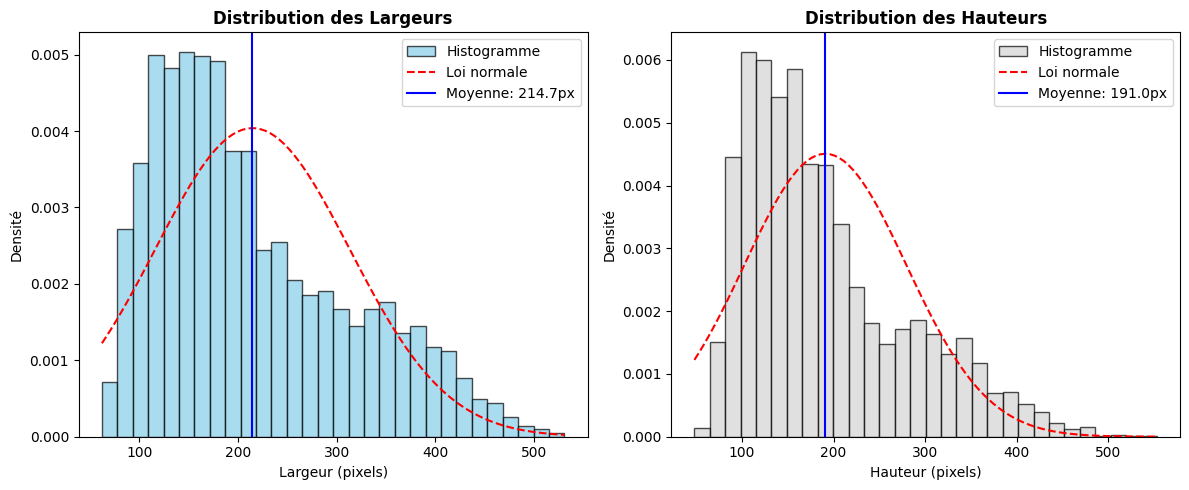

In [15]:
# Paramètres de la loi normale
mu_w, sigma_w = shape_data['width'].mean(), shape_data['width'].std()
mu_h, sigma_h = shape_data['height'].mean(), shape_data['height'].std()

plt.figure(figsize=(12, 5))

# Distribution des largeurs
plt.subplot(1, 2, 1)
shape_data['width'].plot(kind='hist', bins=30, density=True, alpha=0.7, edgecolor='black', color='skyblue', label="Histogramme")
x_vals = np.linspace(shape_data['width'].min(), shape_data['width'].max(), 100)
plt.plot(x_vals, norm.pdf(x_vals, mu_w, sigma_w), 'r--', label='Loi normale')
plt.title('Distribution des Largeurs', fontweight='bold')
plt.xlabel('Largeur (pixels)')
plt.ylabel('Densité')
plt.axvline(mu_w, color='blue', linestyle='-', label=f'Moyenne: {mu_w:.1f}px')
plt.legend()

#  Distribution des hauteurs
plt.subplot(1, 2, 2)
shape_data['height'].plot(kind='hist', bins=30, density=True, alpha=0.7, edgecolor='black', color='lightgrey', label="Histogramme")
x_vals = np.linspace(shape_data['height'].min(), shape_data['height'].max(), 100)
plt.plot(x_vals, norm.pdf(x_vals, mu_h, sigma_h), 'r--', label='Loi normale')
plt.title('Distribution des Hauteurs', fontweight='bold')
plt.xlabel('Hauteur (pixels)')
plt.ylabel('Densité')
plt.axvline(mu_h, color='blue', linestyle='-', label=f'Moyenne: {mu_h:.1f}px')
plt.legend()

plt.tight_layout()
plt.show()

Les histogrammes des largeurs et des hauteurs ne forment pas une cloche centrée.
La courbe normale (rouge pointillée) ne colle pas bien à la forme de l’histogramme.
Il y a un étalement vers la droite, c’est-à-dire qu’il y a quelques images avec une largeur ou hauteur bien plus grande que la moyenne. En d'autres termes : 
-   La majorité des images ont des tailles modérées (pas trop éloignés de la moyenne)
-   Il y a une minorité d’images très grandes, qui tirent la moyenne vers la droite

Après avoir regarder les longueurs et hauteurs de manière séparée, nous allons voir les dimensions de manières générales (largeur et hauteur)

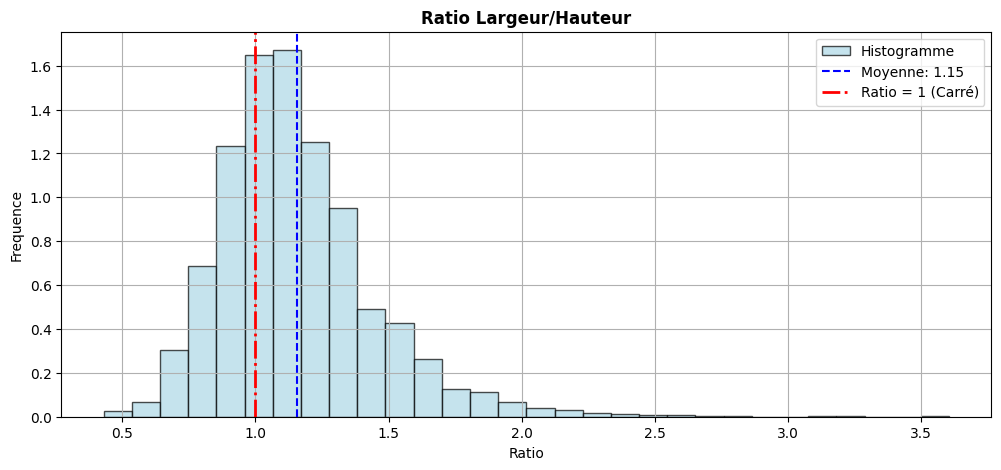

In [16]:
shape_data['ratio'] = shape_data['width'] / shape_data['height']

#  Distribution des hauteurs
plt.figure(figsize=(12, 5))
shape_data['ratio'].plot(kind='hist', bins=30, density=True, alpha=0.7,
                        edgecolor='black', color='lightblue', label="Histogramme")
plt.axvline(shape_data['ratio'].mean(), color='blue', linestyle='--', label=f"Moyenne: {shape_data['ratio'].mean():.2f}")
plt.axvline(1, color='red', linestyle='-.', linewidth=2, label="Ratio = 1 (Carré)")
plt.title('Ratio Largeur/Hauteur', fontweight='bold')
plt.xlabel('Ratio')
plt.ylabel('Frequence')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
print("% d\'images de ratio > 1 \n", shape_data[shape_data['ratio']>1].count()/shape_data.count() * 100)
print("===="*10)
print("% d\'images de ratio < 1 \n", shape_data[shape_data['ratio']<1].count()/shape_data.count() * 100)
print("===="*10)
print("% d\'images de ratio = 1 \n", shape_data[shape_data['ratio']==1].count()/shape_data.count() * 100)

% d'images de ratio > 1 
 path      68.955298
label     68.955298
width     68.955298
height    68.955298
ratio     68.955298
dtype: float64
% d'images de ratio < 1 
 path      30.180291
label     30.180291
width     30.180291
height    30.180291
ratio     30.180291
dtype: float64
% d'images de ratio = 1 
 path      0.864411
label     0.864411
width     0.864411
height    0.864411
ratio     0.864411
dtype: float64


Le ratio moyen est de 1.15, qui n'est pas trop du ratio d'une image carrée (1). Nous remarquons également qu'il y a plus d'images longues en largeur.

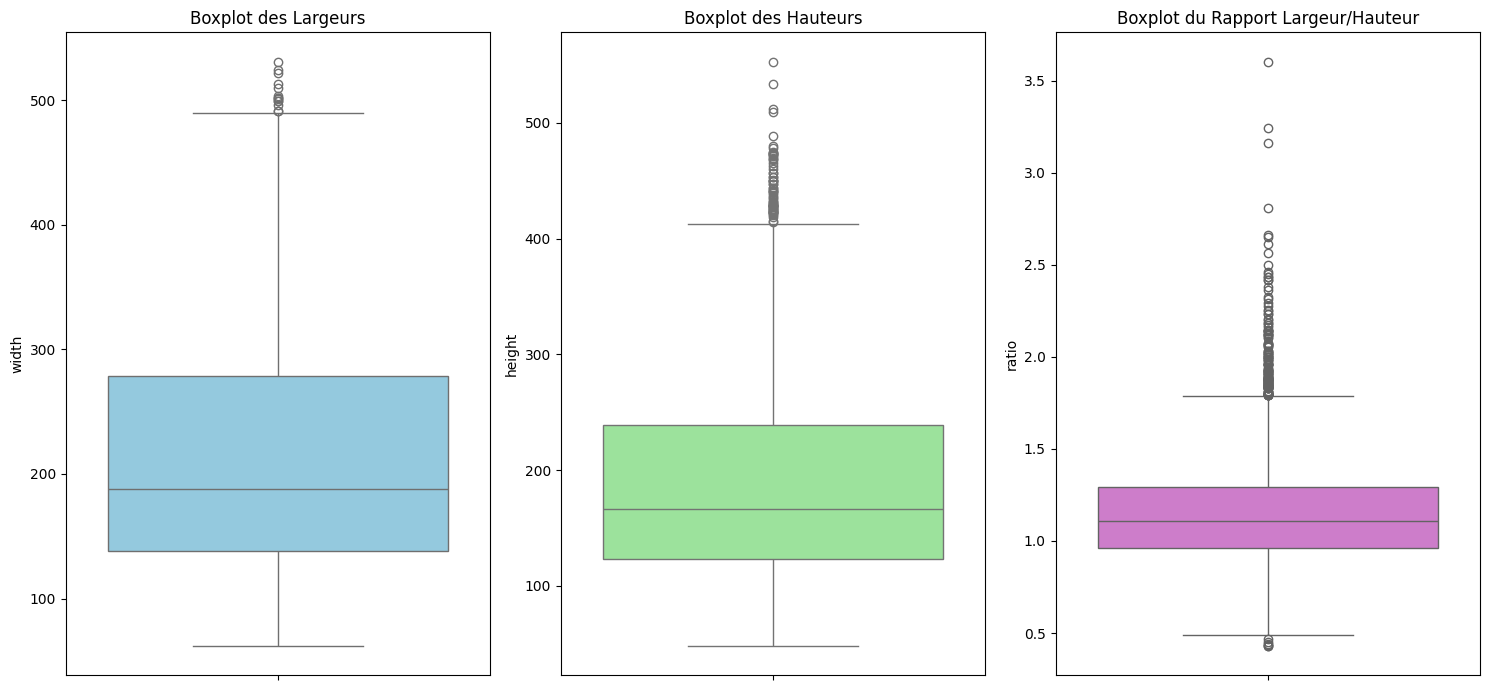

In [18]:
# Boxplots largeur, hauteur et aspect ratio
plt.figure(figsize=(15, 7))

plt.subplot(1, 3, 1)
sns.boxplot(y=shape_data['width'], color="skyblue")
plt.title("Boxplot des Largeurs")

plt.subplot(1, 3, 2)
sns.boxplot(y=shape_data['height'], color="lightgreen")
plt.title("Boxplot des Hauteurs")

plt.subplot(1, 3, 3)
sns.boxplot(y=shape_data['ratio'], color="orchid")
plt.title("Boxplot du Rapport Largeur/Hauteur")

plt.tight_layout()
plt.show()


In [ ]:
# Fonction pour détecter les outliers en dimensions d'image
def detect_outliers(series, col: str):
    Q1 = series[col].quantile(0.25)
    Q3 = series[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series[col] < lower) | (series[col] > upper)]


In [20]:
out_width = detect_outliers(shape_data, 'width')
out_height = detect_outliers(shape_data, 'height')
out_ratio = detect_outliers(shape_data, 'ratio')

# Nombre de outliers en fonction des caractéristiques
print(f"Outliers largeur : {len(out_width)} images")
print(f"Outliers hauteur : {len(out_height)} images")
print(f"Outliers ratio   : {len(out_ratio)} images")

Outliers largeur : 14 images
Outliers hauteur : 68 images
Outliers ratio   : 148 images


In [21]:
out_width

path  \
1803  ../data/im_Metaplastic/im_Metaplastic/CROPPED/...   
2761  ../data/im_Parabasal/im_Parabasal/CROPPED/047_...   
3225  ../data/im_Superficial-Intermediate/im_Superfi...   
3265  ../data/im_Superficial-Intermediate/im_Superfi...   
3282  ../data/im_Superficial-Intermediate/im_Superfi...   
3387  ../data/im_Superficial-Intermediate/im_Superfi...   
3413  ../data/im_Superficial-Intermediate/im_Superfi...   
3460  ../data/im_Superficial-Intermediate/im_Superfi...   
3479  ../data/im_Superficial-Intermediate/im_Superfi...   
3494  ../data/im_Superficial-Intermediate/im_Superfi...   
3518  ../data/im_Superficial-Intermediate/im_Superfi...   
3553  ../data/im_Superficial-Intermediate/im_Superfi...   
3630  ../data/im_Superficial-Intermediate/im_Superfi...   
4014  ../data/im_Superficial-Intermediate/im_Superfi...   

                            label  width  height     ratio  
1803               im_Metaplastic    503     159  3.163522  
2761                 im_Parabasal    502     267  1.880150  
3225  im_Superficial-Intermediate    502     453  1.108168  
3265  im_Superficial-Intermediate    491     380  1.292105  
3282  im_Superficial-Intermediate    524     409  1.281174  
3387  im_Superficial-Intermediate    499     321  1.554517  
3413  im_Superficial-Intermediate    499     386  1.292746  
3460  im_Superficial-Intermediate    491     322  1.524845  
3479  im_Superficial-Intermediate    531     278  1.910072  
3494  im_Superficial-Intermediate    513     381  1.346457  
3518  im_Superficial-Intermediate    510     310  1.645161  
3553  im_Superficial-Intermediate    501     323  1.551084  
3630  im_Superficial-Intermediate    496     357  1.389356  
4014  im_Superficial-Intermediate    522     280  1.864286

Nous observons qu'il y a des valeurs aberrantes sur les largeurs et hauteurs des images. Ces valeurs sont souvent très grandes par rapport aux dimensions des images du groupe. Cela sera prise en compte dans la création du pipeline la fixation de dimensions pas trop élevées sur les fichiers images.

In [22]:
# Outliers par classe
count_width = out_width.groupby("label").size()
count_height = out_height.groupby("label").size()
count_ratio = out_ratio.groupby("label").size()

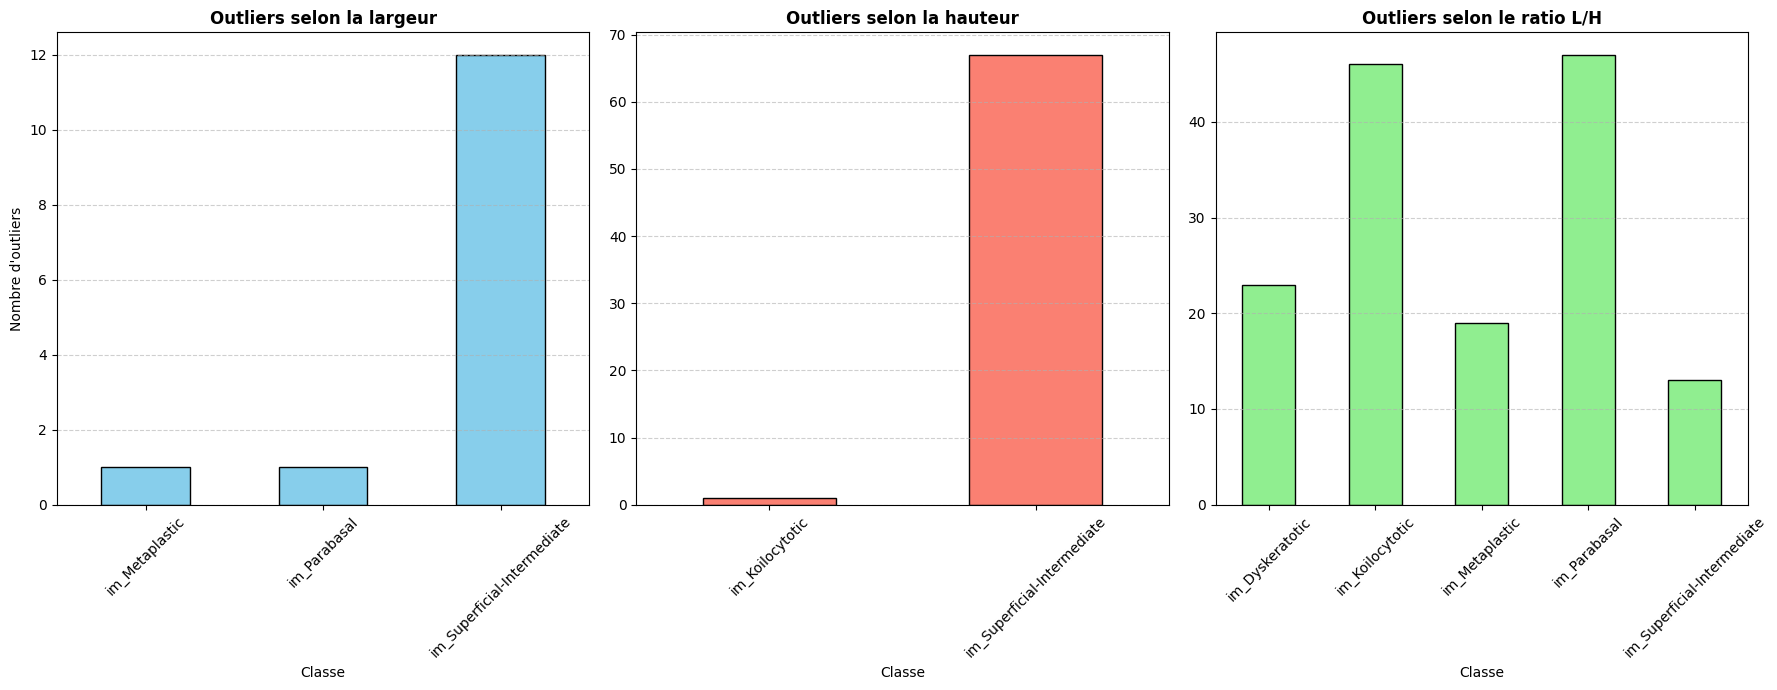

In [23]:
plt.figure(figsize=(18, 7))

# Largeur
plt.subplot(1, 3, 1)
count_width.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Outliers selon la largeur", fontweight='bold')
plt.xlabel("Classe")
plt.ylabel("Nombre d'outliers")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Hauteur
plt.subplot(1, 3, 2)
count_height.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Outliers selon la hauteur", fontweight='bold')
plt.xlabel("Classe")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ratio
plt.subplot(1, 3, 3)
count_ratio.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Outliers selon le ratio L/H", fontweight='bold')
plt.xlabel("Classe")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


<Figure size 1200x500 with 0 Axes>

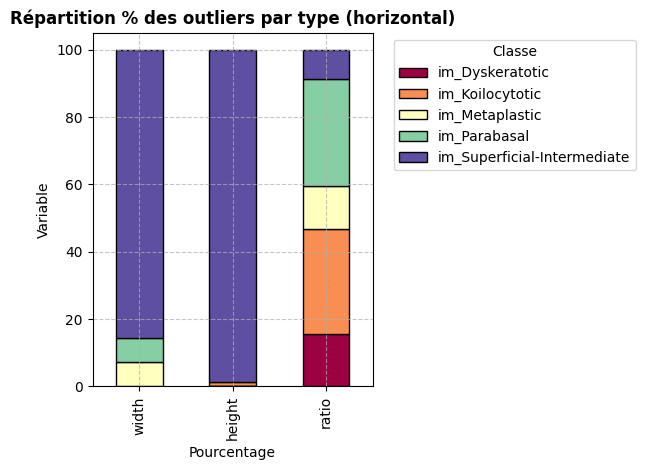

In [24]:
# Fusion des counts dans un même DataFrame (index = classes, colonnes = type d’outliers)
outlier_counts = pd.DataFrame({
    'width': count_width,
    'height': count_height,
    'ratio': count_ratio
}).fillna(0).astype(int)

outlier_counts_T = outlier_counts.T  # Lignes = variables, colonnes = classes

# Normalisation des barres à 100 %
outlier_pct = outlier_counts_T.div(outlier_counts_T.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 5))
outlier_pct.plot(kind='bar', stacked=True, colormap=cm.Spectral, edgecolor='black')

plt.title("Répartition % des outliers par type (horizontal)", fontweight='bold')
plt.xlabel("Pourcentage")
plt.ylabel("Variable")
plt.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Visualisation des contours/cellules (segmentation brute)

Il s'agit de l'analyse morphologique. L'bjectif de cette partie est de mettre en évidence les bords/contours des cellules pour chaque classe.

In [25]:
def plot_contours_per_class(base_dir, classes, num_images=3):
    plt.figure(figsize=(num_images * 4, len(classes) * 4))
    img_index = 1

    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(base_dir, class_name, class_name, "CROPPED")
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith('.bmp')]
        random.shuffle(image_files)
        
        for i in range(num_images):
            img_path = os.path.join(class_path, image_files[i])
            original = cv2.imread(img_path)
            gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

            # Afficher image originale
            plt.subplot(len(classes), num_images * 2, img_index)
            plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
            plt.title(f"{class_name} - Originale", fontsize=10, rotation=45)
            plt.axis('off')
            img_index += 1

            # Afficher contours
            plt.subplot(len(classes), num_images * 2, img_index)
            plt.imshow(edges, cmap='gray')
            plt.title(f"{class_name} - Contours", fontsize=10, rotation=45)
            plt.axis('off')
            img_index += 1

    plt.tight_layout()
    plt.show()

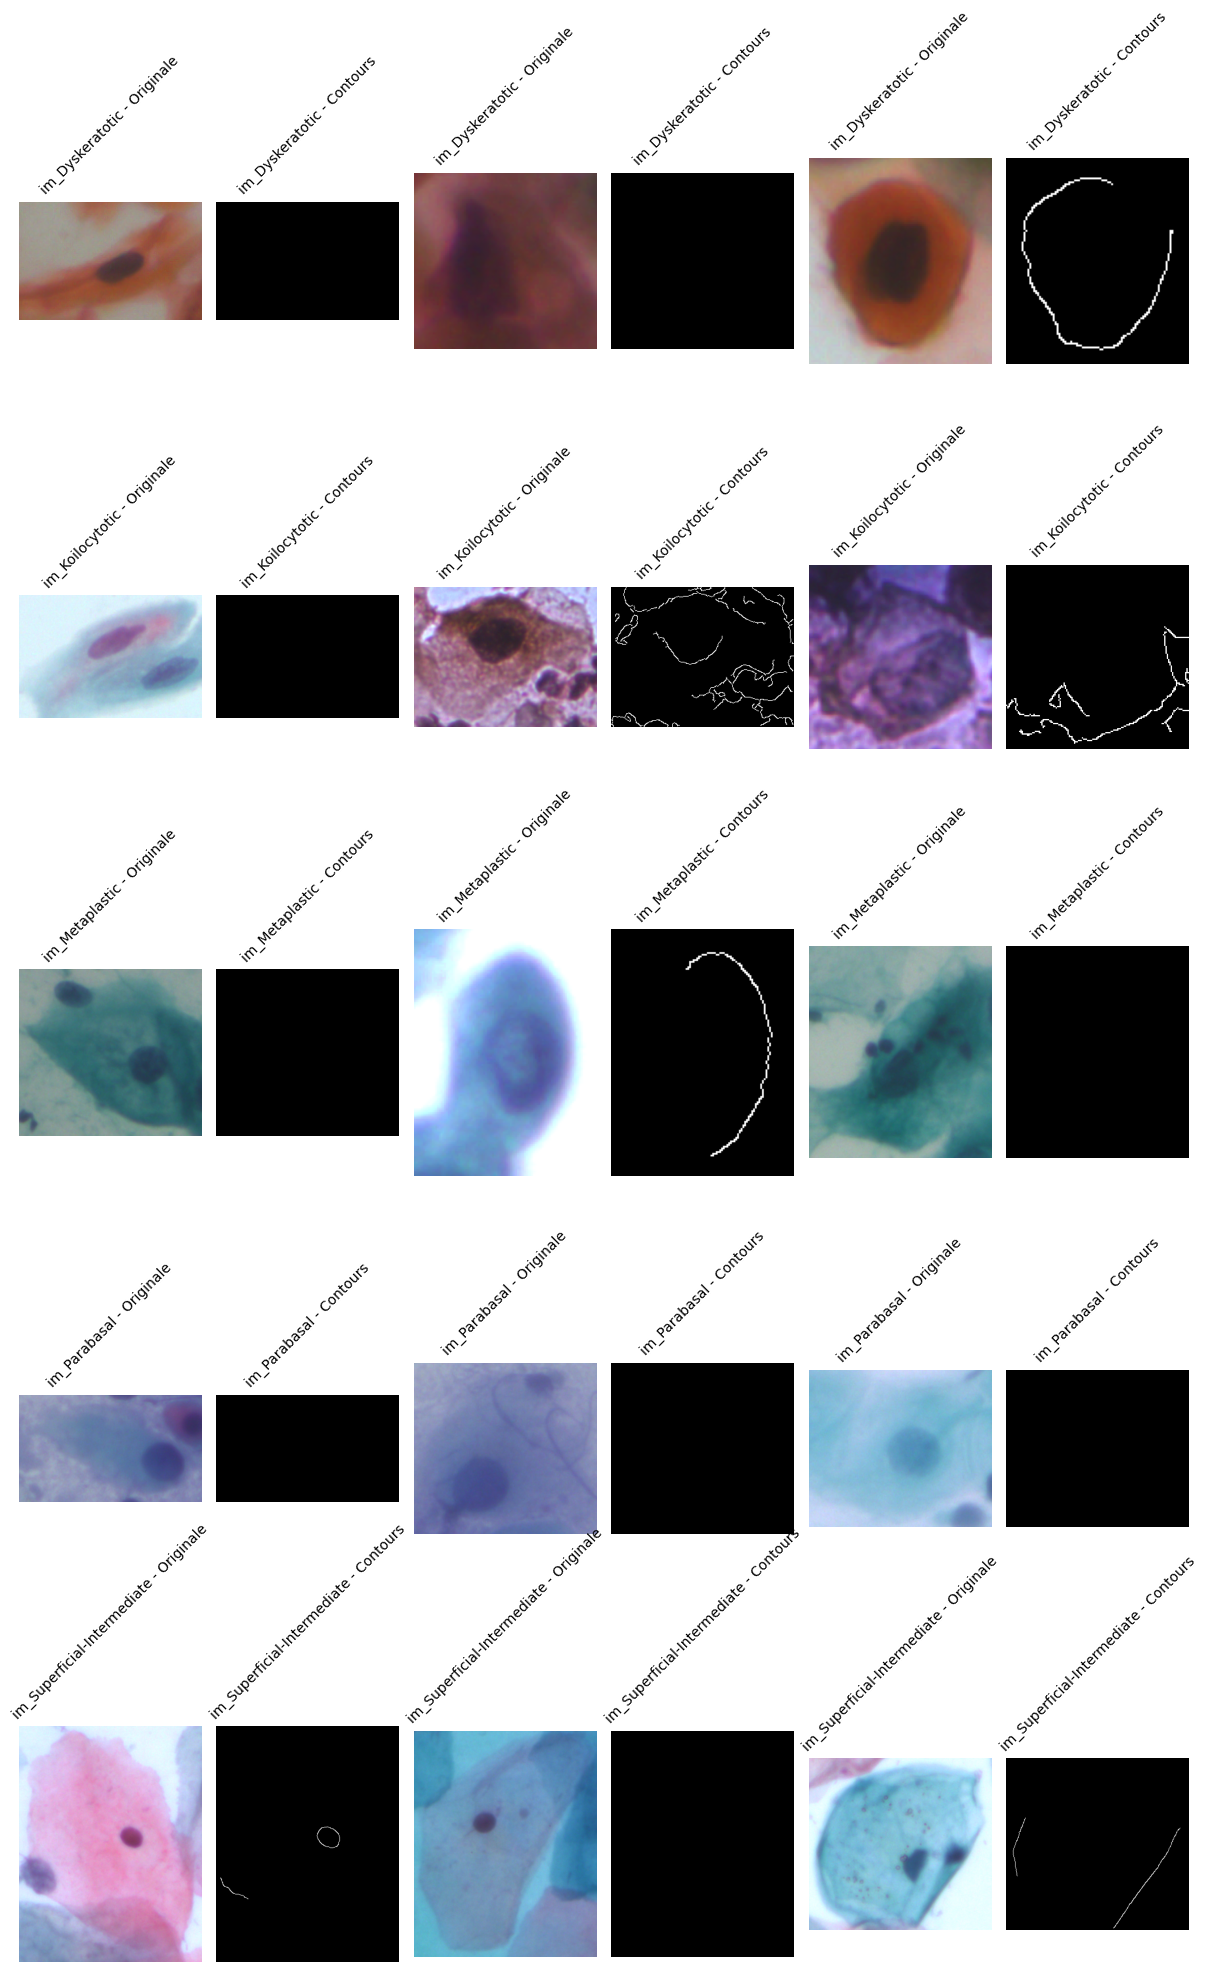

In [26]:
plot_contours_per_class(DATA_PATH, classes, num_images=3)

Beaucoup de contours sont entièrement noirs. En effet, le filtrage Canny ne détecte rien, souvent à cause d’un manque de contraste ou d’un seuil mal calibré (problèmes liés à la qualité de l'image). Cette non détection des contours pourrait aussi être due aux formes des cellules qui sont souvent arrondies et très entassées de sortee qu'il est difficile d'observer leur délimitation avec certains microscopes (anciens modèles);

In [27]:
def extract_morph_features(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return {'area': 0, 'perimeter': 0, 'circularity': 0, 'n_contours': 0}

    c = max(contours, key=cv2.contourArea)  # plus gros contour
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

    return {
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity, # Rondeur de la cellule
        'n_contours': len(contours)
    }


In [28]:
print(extract_morph_features(data['path'][0]))
print("===="*10)
extract_morph_features(data['path'][2000])

{'area': 0, 'perimeter': 0, 'circularity': 0, 'n_contours': 0}


{'area': 28.0,
 'perimeter': 168.65180158615112,
 'circularity': 0.012370462176923334,
 'n_contours': 3}

## Statistiques de couleur (moyenne, écart-type par canal RGB)

In [29]:
morph_data = []

for path, label in zip(data['path'], data['label']):
    features = extract_morph_features(path)
    features['label'] = label
    morph_data.append(features)

morph_df = pd.DataFrame(morph_data)

label
im_Parabasal                   784
im_Dyskeratotic                609
im_Metaplastic                 514
im_Superficial-Intermediate    340
im_Koilocytotic                294
Name: count, dtype: int64


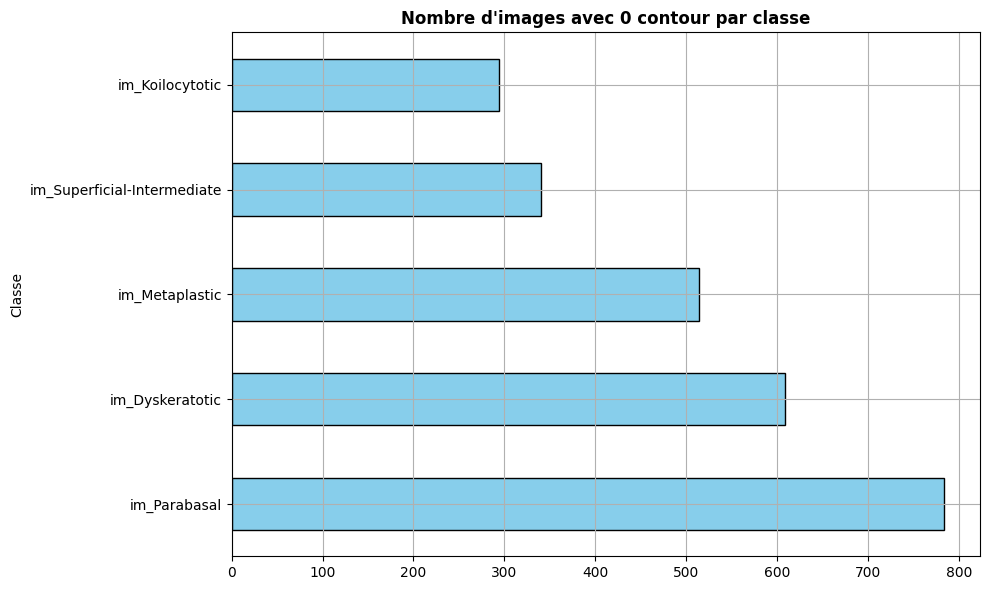

In [30]:
zero_contours_per_class = morph_df[morph_df['n_contours'] == 0]['label'].value_counts()
print(zero_contours_per_class)

plt.figure(figsize=(10, 6))
zero_contours_per_class.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Nombre d'images avec 0 contour par classe", fontsize=12, fontweight='bold')
plt.ylabel("Classe")
plt.grid()
plt.tight_layout()
plt.show()


Nous constatons que pour la plupart des images, les countours ne sont pas détectables. Il s'agit en particulier des cellules parabasal, dyskeratotic et metaplastic.

## Analyse de texture (Haralick, GLCM)

Les caractéristiques texturales permettent de capturer la structure locale des images (granularité, répétition, orientation, etc.)

### GLCM – Gray-Level Co-occurrence Matrix
C’est la méthode la plus utilisée. Elle mesure comment les intensités de gris se répètent dans une image selon une distance et une direction.

A partir de la GLCM, on extrait plusieurs descripteurs :

-   Contrast : variation locale des niveaux de gris.

-   Correlation : corrélation entre pixels voisins.

-   Energy : homogénéité (valeurs élevées = texture uniforme).

-   Homogeneity : distribution proche de la diagonale = peu de contraste.

In [31]:
def extract_texture_features(img_path, distances=[1], angles=[0]):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Quantification des niveaux de gris (par exemple 8 niveaux pour simplifier)
    gray = (gray / 32).astype(np.uint8)  # 256 / 8 = 32

    glcm = graycomatrix(gray, 
                        distances=distances, 
                        angles=angles, 
                        symmetric=True, 
                        normed=True)

    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
    }

    return features


In [32]:
texture_data = []

for path, label in zip(data['path'], data['label']):
    feats = extract_texture_features(path)
    feats['label'] = label
    texture_data.append(feats)

texture_df = pd.DataFrame(texture_data)


In [33]:
texture_df['correlation']

0       0.969104
1       0.973170
2       0.978360
3       0.969246
4       0.970097
          ...   
4044    0.973478
4045    0.960064
4046    0.966768
4047    0.976173
4048    0.963022
Name: correlation, Length: 4049, dtype: float64

In [34]:
classes = sorted(texture_df['label'].unique())
features = ['contrast', 'correlation', 'energy', 'homogeneity']
colors = ["#C8DCD6", "#ecd0c5", "#c3d3f7", "#a4fad7"]  # Une couleur par boxplot (facultatif)

## Detection d'images corrompues

In [35]:
def show_random_images_with_texture(base_dir, classes, num_images=3):
    plt.figure(figsize=(num_images * 4, len(classes) * 4))
    idx = 1

    for cls in classes:
        cls_dir = os.path.join(base_dir, cls, cls, "CROPPED")
        files   = [f for f in os.listdir(cls_dir) if f.lower().endswith('.bmp')]
        sample  = random.sample(files, min(num_images, len(files)))

        for f in sample:
            path = os.path.join(cls_dir, f)
            img  = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            feats = extract_texture_features(path)

            plt.subplot(len(classes), num_images, idx)
            plt.imshow(img); plt.axis('off')
            plt.title(
                f"{cls}\n"
                f"C:{feats['contrast']:.3f}  "
                f"E:{feats['energy']:.3f}\n"
                f"Co:{feats['correlation']:.3f}  "
                f"H:{feats['homogeneity']:.3f}",
                fontsize=8
            )
            idx += 1

    plt.tight_layout()
    plt.show()

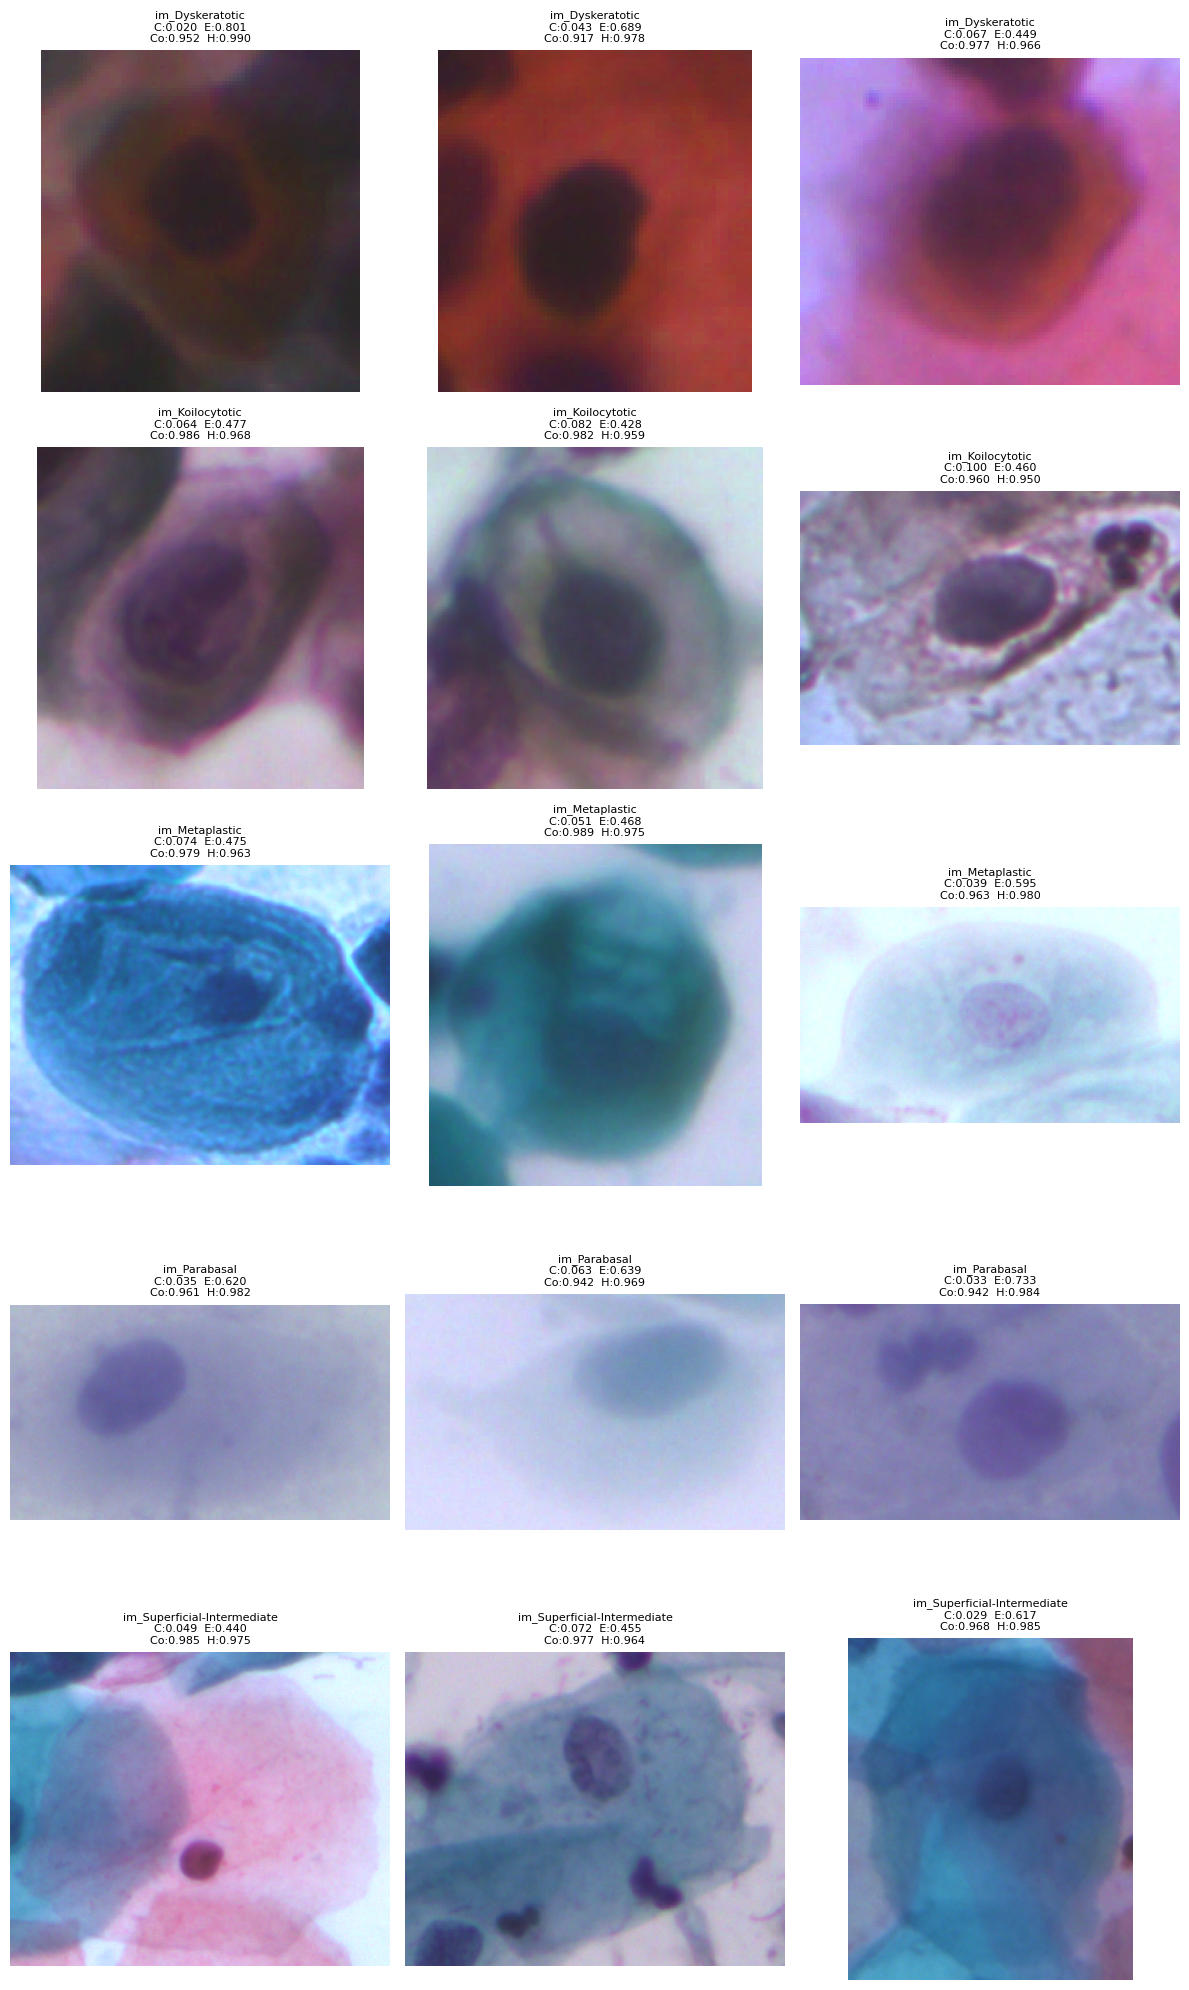

In [36]:
show_random_images_with_texture(DATA_PATH, classes)

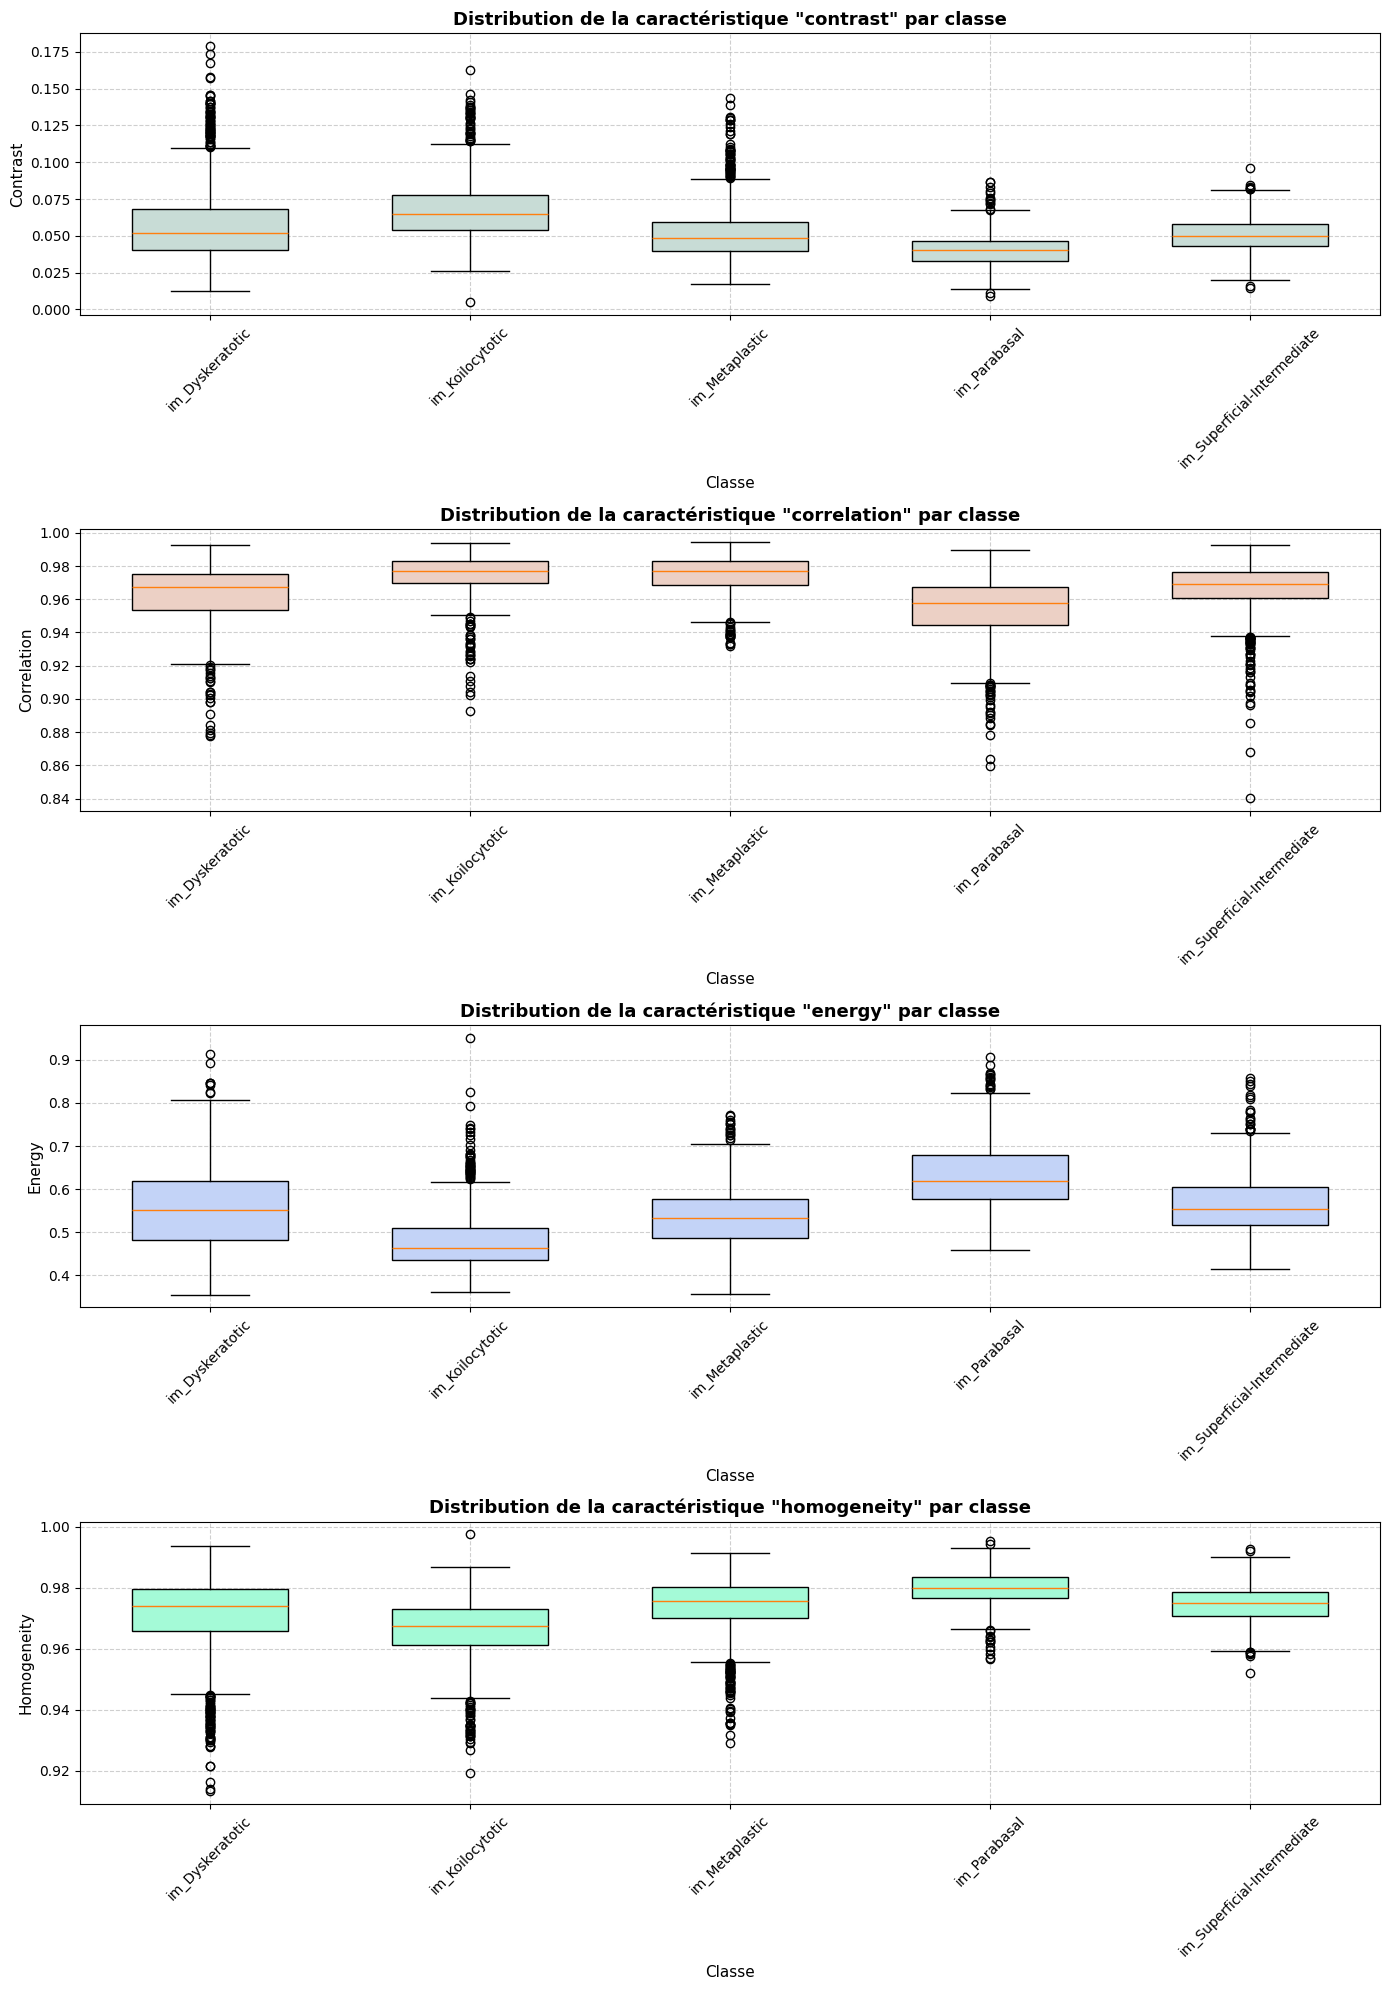

In [37]:
plt.figure(figsize=(14, 20))

for i, feature in enumerate(features):
    plt.subplot(4, 1, i + 1)

    # Liste des valeurs par classe
    data_per_class = [texture_df[texture_df['label'] == label][feature] for label in classes]

    # Boxplot avec options
    box = plt.boxplot(data_per_class, patch_artist=True, tick_labels=classes, widths=0.6)

    # Couleurs des boîtes
    for patch, color in zip(box['boxes'], [colors[i]] * len(classes)):
        patch.set_facecolor(color)

    plt.title(f'Distribution de la caractéristique "{feature}" par classe', fontsize=13, fontweight='bold')
    plt.xlabel('Classe', fontsize=11)
    plt.ylabel(feature.capitalize(), fontsize=11)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## PCA sur des descripteurs simples

Cette partie permet juste de voir si les cellules sont classables à l'aide des caractéristiques calculées en utilisant une méthode de réduction de dimension.

In [38]:
df = pd.merge(texture_df, morph_df, on='label')
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3280373 entries, 0 to 3280372
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   contrast     float64
 1   correlation  float64
 2   energy       float64
 3   homogeneity  float64
 4   label        object 
 5   area         float64
 6   perimeter    float64
 7   circularity  float64
 8   n_contours   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 225.2+ MB


### ACP


In [39]:
# Sélection des features et des labels
X = df[['area', 'perimeter', 'circularity', 'n_contours', 
                'contrast', 'correlation', 'energy', 'homogeneity']]
y = df['label']

# Normalisation (très important avant une PCA)
scaler = StandardScaler()

In [40]:
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'label': y
})

In [41]:
inertie = pca.explained_variance_ratio_

In [42]:
print("Variance expliquée par les 3 premières composantes :", sum(inertie))

Variance expliquée par les 3 premières composantes : 0.7072654822463302


Les 3 premières axes permettent de résumer de 70.73% de l'information contenue sur les caractéristiques extraites des images.

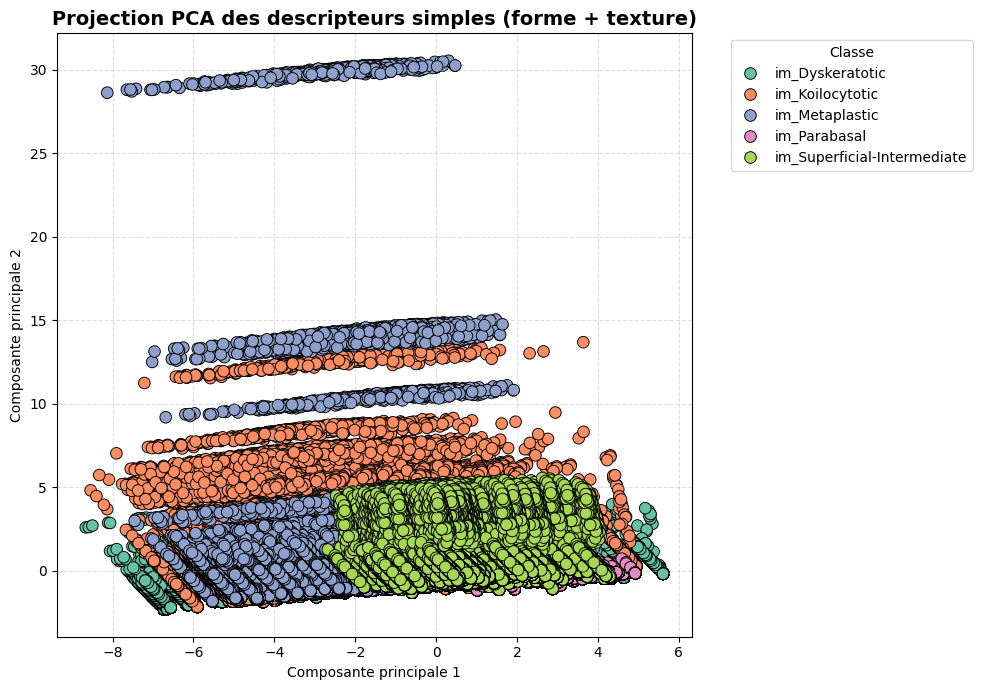

In [43]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='label', palette='Set2', s=70, edgecolor='k')
plt.title('Projection PCA des descripteurs simples (forme + texture)', fontsize=14, fontweight='bold')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend(title='Classe', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Le graphe ne permet pas dispacher les différentes classes.

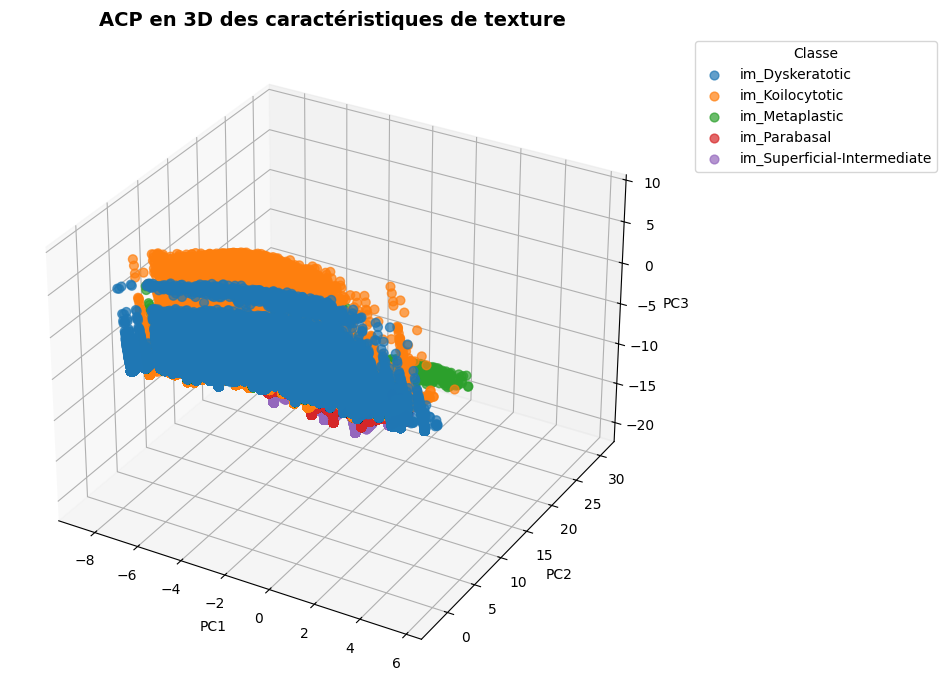

In [44]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Encodage des couleurs pour chaque classe
unique_labels = sorted(y.unique())
colors = plt.cm.tab10(range(len(unique_labels)))

for label, color in zip(unique_labels, colors):
    idx = y == label
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2],
               label=label, alpha=0.7, s=40, color=color)

ax.set_title("ACP en 3D des caractéristiques de texture", fontsize=14, fontweight='bold')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

La visualisation semble plus visible par rapport à celle précédente avec les 3 axes. Néanmoins, on remarque toujours une superposition des points de données. Cela suggère que les données sont corrélées.
On en déduit que l'ACP ne permet pas de distinguer les variables.

Nous pouvons faire recours à d'autres méthodes plus performantes pour faire la classification.

In [45]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# X_tsne = tsne.fit_transform(X_scaled)


In [46]:
# import plotly.express as px

# fig = px.scatter(x=X_tsne[:,0], y=X_tsne[:,1], color=labels, title='t-SNE en 2D')
# fig.show()


In [47]:
# tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
# X_tsne_3d = tsne_3d.fit_transform(X_scaled)

# Train, Test split

In [14]:
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# Preprocessing

In [15]:
from pipeline import ImageReader, ResizeAndPad, EnhanceQuality, DataAugmentation, Normalize

train_pipeline = Pipeline([
    ('reader', ImageReader(target_size=224)),
    ('resize_pad', ResizeAndPad(target_size=224)),
    ('enhance', EnhanceQuality(blur_thresh=100, bright_thresh=50)),
    ('augment', DataAugmentation(p_flip=0.5, max_rotation=15)),
    ('normalize', Normalize())
])
train_pipeline


Pipeline(steps=[('reader', ImageReader()), ('resize_pad', ResizeAndPad()),
                ('enhance', EnhanceQuality()), ('augment', DataAugmentation()),
                ('normalize', Normalize())])

In [16]:
test_pipeline = Pipeline([
    ('reader', ImageReader(target_size=224)),
    ('resize_pad', ResizeAndPad(target_size=224)),
    ('enhance', EnhanceQuality(blur_thresh=100, bright_thresh=50)),
    # ('augment', DataAugmentation(p_flip=0.5, max_rotation=15)),
    ('normalize', Normalize())
])
test_pipeline

Pipeline(steps=[('reader', ImageReader()), ('resize_pad', ResizeAndPad()),
                ('enhance', EnhanceQuality()), ('normalize', Normalize())])

In [18]:
# X pour les features d'images
# y pour le target
X_train = train_data['path']
y_train = train_data['label']

X_test = test_data['path']
y_test = test_data['label']


In [19]:
X_train_proc = train_pipeline.fit_transform(X_train)
X_test_proc = test_pipeline.transform(X_test)

Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcem

c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project_loc\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [20]:
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train), num_classes=5)
y_test_enc  = to_categorical(le.transform(y_test), num_classes=5)

# Modélisation

## CNN classique

In [54]:
model0 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='valid'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model0.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
model0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,717 (45.64 MB)

 Trainable params: 11,963,717 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history0 = model0.fit(
    X_train_proc, y_train_enc,
    validation_split=0.1, 
    epochs=20,
    batch_size=32,
    shuffle=True
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 420ms/step - accuracy: 0.4302 - loss: 1.8291 - val_accuracy: 0.6204 - val_loss: 0.9377
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 273ms/step - accuracy: 0.6816 - loss: 0.8783 - val_accuracy: 0.7315 - val_loss: 0.7242
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 269ms/step - accuracy: 0.7330 - loss: 0.7294 - val_accuracy: 0.7130 - val_loss: 0.7374
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 273ms/step - accuracy: 0.7607 - loss: 0.6349 - val_accuracy: 0.6944 - val_loss: 0.7914
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step - accuracy: 0.7795 - loss: 0.5840 - val_accuracy: 0.6975 - val_loss: 0.7482
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 386ms/step - accuracy: 0.8076 - loss: 0.5193 - val_accuracy: 0.7870 - val_loss: 0.5898
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - accuracy: 0.8374 - loss: 0.4483 - val_accuracy: 0.8148 - val_loss: 0.4713
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 268ms/step - accuracy: 0.8643 - loss: 0.3754 - val_accu

In [57]:
loss_train, acc_train = model0.evaluate(X_train_proc, y_train_enc, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {acc_train:.2%}")

Train Loss: 0.1278
Train Accuracy: 96.82%


In [58]:
loss_test, acc_test = model0.evaluate(X_test_proc, y_test_enc, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.2%}")

Test Loss: 0.8360
Test Accuracy: 79.01%


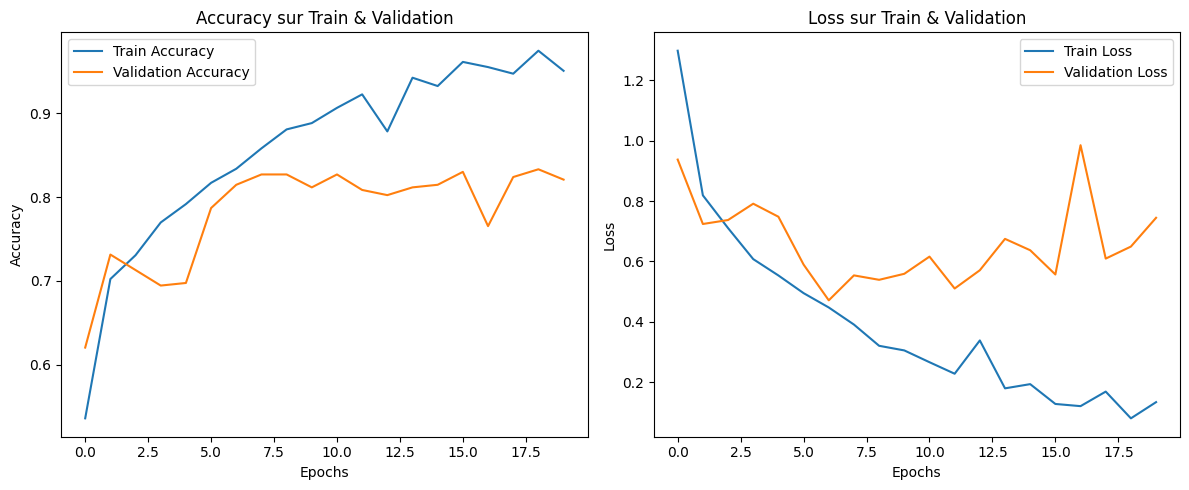

In [ ]:
# Courbe de précision
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history0.history['accuracy'], label='Train Accuracy')
plt.plot(history0.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy sur Train & Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Courbe de perte
plt.subplot(1,2,2)
plt.plot(history0.history['loss'], label='Train Loss')
plt.plot(history0.history['val_loss'], label='Validation Loss')
plt.title("Loss sur Train & Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


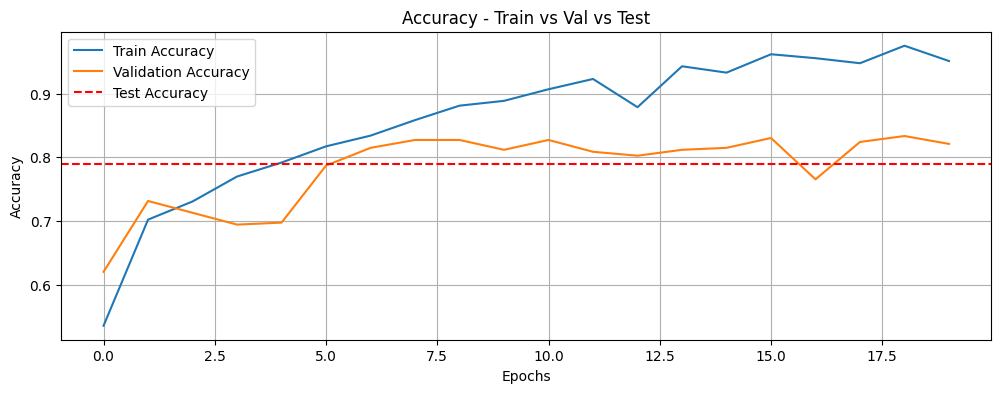

In [60]:
# Performance sur le train et le test
plt.figure(figsize=(12,4))
plt.plot(history0.history['accuracy'], label='Train Accuracy')
plt.plot(history0.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_test, color='red', linestyle='--', label='Test Accuracy')
plt.title("Accuracy - Train vs Val vs Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Nous remarquons que la précision sur le train est supérieure à celle du test, ce qui indique 
un léger sur-apprentissage. Cependant, la précision sur le test reste raisonnable, ce qui suggère 
que le modèle généralise bien malgré une légère tendance à sur-apprendre. Nous allons donc revenir sur les pré-traitements. En effet, l'augmentation des données pourraient être la source de ce problème. Il ne parait limité dans le cas de notre où les cellules sont de forme arrondie les rotations pourraient ne pas être déterminants dans la classification.

In [61]:
train_pipeline = Pipeline([
    ('reader', ImageReader(target_size=224)),
    ('resize_pad', ResizeAndPad(target_size=224)),
    ('enhance', EnhanceQuality(blur_thresh=100, bright_thresh=50)),
    ('augment', DataAugmentation(p_flip=0.6, max_rotation=30)),
    ('normalize', Normalize())
])

test_pipeline = Pipeline([
    ('reader', ImageReader(target_size=224)),
    ('resize_pad', ResizeAndPad(target_size=224)),
    ('enhance', EnhanceQuality(blur_thresh=100, bright_thresh=50)),
    # ('augment', DataAugmentation(p_flip=0.5, max_rotation=15)),
    ('normalize', Normalize())
])

X_train_reproc = train_pipeline.fit_transform(X_train)
X_test_reproc = test_pipeline.transform(X_test)

model00 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='valid'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model00.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model00.summary()

Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
💡 Sombre détecté : CLAHE appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcement des contours appliqué
Image floue: renforcem

c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,717 (45.64 MB)

 Trainable params: 11,963,717 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history00 = model00.fit(
    X_train_reproc, y_train_enc,
    validation_split=0.1, 
    epochs=20,
    batch_size=32,
    shuffle=True
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 344ms/step - accuracy: 0.2818 - loss: 4.1067 - val_accuracy: 0.3117 - val_loss: 1.4819
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 317ms/step - accuracy: 0.4531 - loss: 1.3879 - val_accuracy: 0.5000 - val_loss: 1.2976
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 334ms/step - accuracy: 0.4705 - loss: 1.2972 - val_accuracy: 0.6142 - val_loss: 1.0849
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 333ms/step - accuracy: 0.5848 - loss: 1.0823 - val_accuracy: 0.6235 - val_loss: 1.0063
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 339ms/step - accuracy: 0.6712 - loss: 0.9606 - val_accuracy: 0.6790 - val_loss: 0.9545
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 336ms/step - accuracy: 0.6708 - loss: 0.9627 - val_accuracy: 0.6142 - val_loss: 0.9753
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 333ms/step - accuracy: 0.7275 - loss: 0.7714 - val_accuracy: 0.6821 - val_loss: 0.8851
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 335ms/step - accuracy: 0.7453 - loss: 0.7281 - val_accu

In [63]:
loss_train, acc_train = model00.evaluate(X_train_reproc, y_train_enc, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {acc_train:.2%}")

loss_test, acc_test = model00.evaluate(X_test_reproc, y_test_enc, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.2%}")

Train Loss: 0.4065
Train Accuracy: 87.28%
Test Loss: 1.1227
Test Accuracy: 68.02%


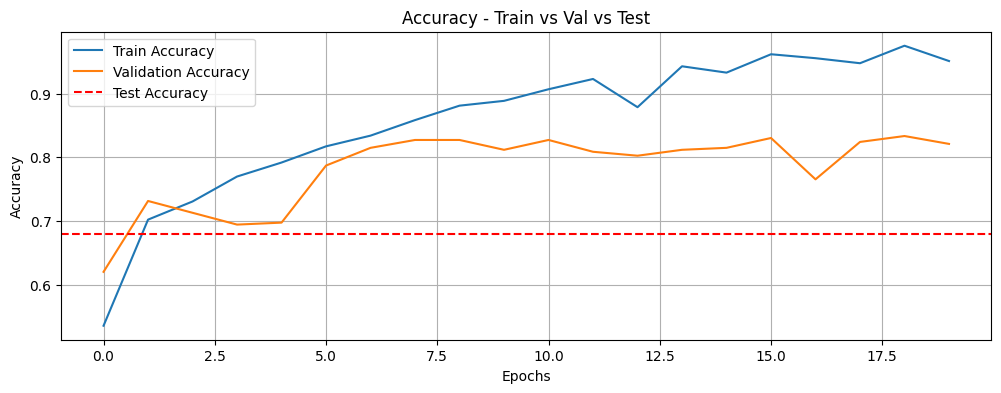

In [64]:
# Performance sur le train et le test
plt.figure(figsize=(12,4))
plt.plot(history0.history['accuracy'], label='Train Accuracy')
plt.plot(history0.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_test, color='red', linestyle='--', label='Test Accuracy')
plt.title("Accuracy - Train vs Val vs Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
model01 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='valid'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model01.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model01.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     5,972,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,991,557 (22.86 MB)

 Trainable params: 5,991,557 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [67]:
history01 = model01.fit(X_train_reproc, y_train_enc, 
          validation_split=0.1,
          epochs=20,
          callbacks=[early_stop])

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 299ms/step - accuracy: 0.2581 - loss: 3.2758 - val_accuracy: 0.3951 - val_loss: 1.3656
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 297ms/step - accuracy: 0.4213 - loss: 1.3482 - val_accuracy: 0.5247 - val_loss: 1.0853
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - accuracy: 0.6028 - loss: 1.0287 - val_accuracy: 0.6975 - val_loss: 0.8536
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.7186 - loss: 0.7806 - val_accuracy: 0.6914 - val_loss: 0.8110
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.7723 - loss: 0.6302 - val_accuracy: 0.6512 - val_loss: 0.8642
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.7734 - loss: 0.6023 - val_accuracy: 0.7469 - val_loss: 0.6871
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - accuracy: 0.8191 - loss: 0.5002 - val_accuracy: 0.7562 - val_loss: 0.6451
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - accuracy: 0.8422 - loss: 0.4473 - val_accu

In [68]:
loss_train, acc_train = model01.evaluate(X_train_reproc, y_train_enc, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {acc_train:.2%}")

loss_test, acc_test = model01.evaluate(X_test_reproc, y_test_enc, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.2%}")

Train Loss: 0.4732
Train Accuracy: 84.78%
Test Loss: 0.7456
Test Accuracy: 70.99%


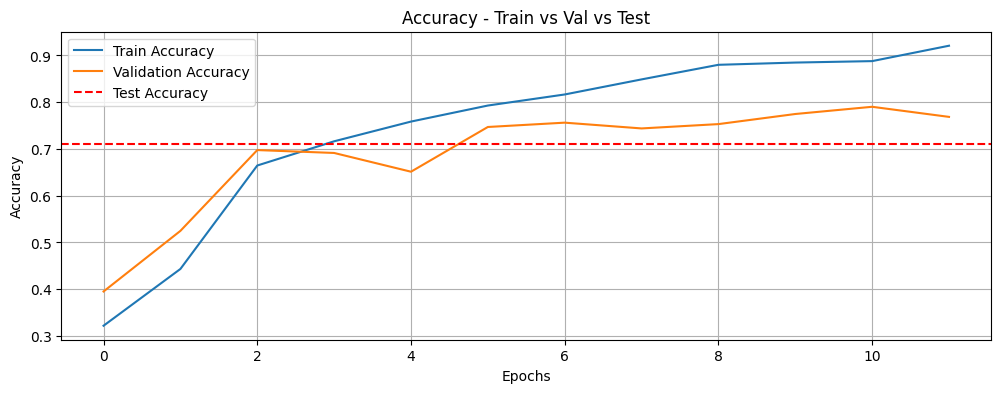

In [69]:
# Performance sur le train et le test
plt.figure(figsize=(12,4))
plt.plot(history01.history['accuracy'], label='Train Accuracy')
plt.plot(history01.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_test, color='red', linestyle='--', label='Test Accuracy')
plt.title("Accuracy - Train vs Val vs Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## MobileNetV2

In [70]:
# Chargement du modele sans le top et sans les poids en ligne
model1 = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights=None)

model1.load_weights('../notebooks/Trained/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

model1.trainable = False

inputs = Input(shape=(224, 224, 3))
x = model1(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x)

model_tl = Model(inputs, outputs)

model_tl.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_tl.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [71]:
history1 = model_tl.fit(X_train_proc, y_train_enc, 
          validation_split=0.1,
          epochs=20,
          callbacks=[early_stop])

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 277ms/step - accuracy: 0.3325 - loss: 1.8029 - val_accuracy: 0.7037 - val_loss: 0.8710
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - accuracy: 0.4875 - loss: 1.2772 - val_accuracy: 0.7716 - val_loss: 0.7109
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.6224 - loss: 1.0311 - val_accuracy: 0.7870 - val_loss: 0.6335
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 257ms/step - accuracy: 0.6697 - loss: 0.8832 - val_accuracy: 0.8025 - val_loss: 0.5795
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 253ms/step - accuracy: 0.6749 - loss: 0.8717 - val_accuracy: 0.8179 - val_loss: 0.5410
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.6921 - loss: 0.8216 - val_accuracy: 0.8148 - val_loss: 0.5169
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step - accuracy: 0.7316 - loss: 0.7377 - val_accuracy: 0.8272 - val_loss: 0.4926
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.7263 - loss: 0.7192 - val_accu

In [72]:
loss_train, acc_train = model_tl.evaluate(X_train_proc, y_train_enc, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {acc_train:.2%}")

loss_test, acc_test = model_tl.evaluate(X_test_proc, y_test_enc, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.2%}")

Train Loss: 0.3577
Train Accuracy: 88.05%
Test Loss: 0.4257
Test Accuracy: 84.94%


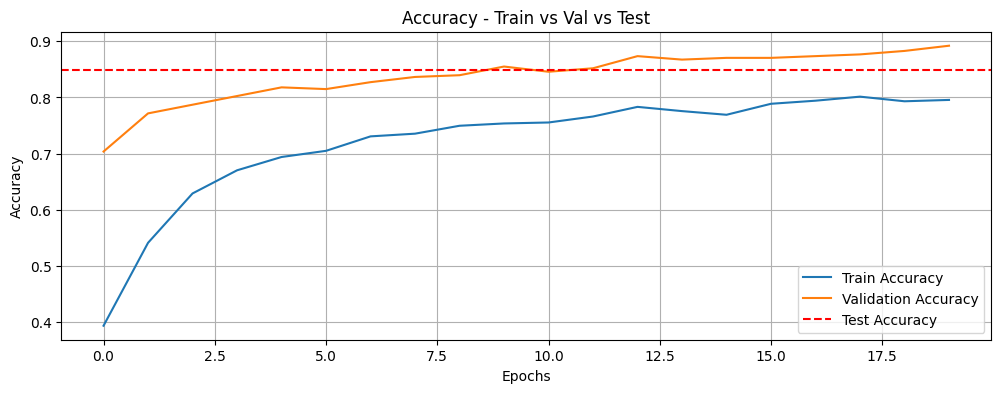

In [73]:
plt.figure(figsize=(12,4))
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_test, color='red', linestyle='--', label='Test Accuracy')
plt.title("Accuracy - Train vs Val vs Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.84      0.90      0.87       163
            im_Koilocytotic       0.81      0.79      0.80       165
             im_Metaplastic       0.79      0.77      0.78       159
               im_Parabasal       0.86      0.80      0.83       157
im_Superficial-Intermediate       0.93      0.98      0.96       166

                   accuracy                           0.85       810
                  macro avg       0.85      0.85      0.85       810
               weighted avg       0.85      0.85      0.85       810



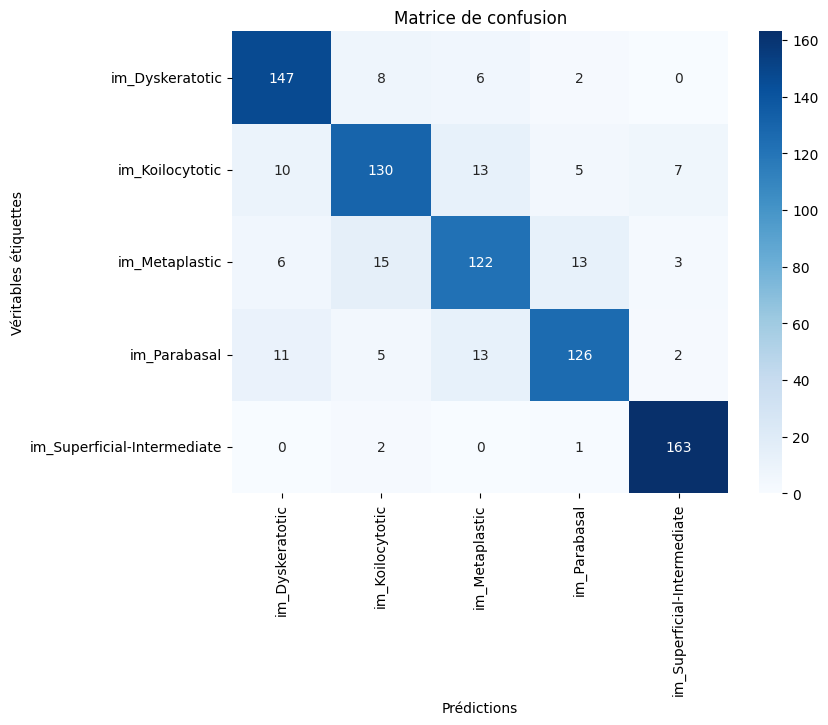

In [74]:
y_pred = model_tl.predict(X_test_proc)     
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_enc, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))
                   
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()


In [75]:
# Sauvegarde du modèle
model_tl.save('../models/mobilenetv2_ccu.h5')

## ResNet50

In [76]:
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False 

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x)

model_resnet = Model(inputs, outputs)

model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_resnet.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [77]:
history2 = model_resnet.fit(X_train_proc, y_train_enc,
                                  validation_split=0.1,
                                  epochs=20,
                                  callbacks=[early_stop])

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.1986 - loss: 2.0285 - val_accuracy: 0.1821 - val_loss: 1.6389
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.2113 - loss: 1.8275 - val_accuracy: 0.2222 - val_loss: 1.6254
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.2106 - loss: 1.7202 - val_accuracy: 0.1821 - val_loss: 1.6119
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.2165 - loss: 1.6875 - val_accuracy: 0.1821 - val_loss: 1.6068
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.2039 - loss: 1.6828 - val_accuracy: 0.1821 - val_loss: 1.6039
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.2140 - loss: 1.6588 - val_accuracy: 0.1914 - val_loss: 1.6058
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.2188 - loss: 1.6479 - val_accuracy: 0.1975 - val_loss: 1.6051
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.2106 - loss: 1.6464 - val_accuracy: 0.1944 - va

In [78]:
loss_train, acc_train = model_resnet.evaluate(X_train_proc, y_train_enc, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {acc_train:.2%}")

loss_test, acc_test = model_resnet.evaluate(X_test_proc, y_test_enc, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.2%}")

Train Loss: 1.6048
Train Accuracy: 20.38%
Test Loss: 1.6038
Test Accuracy: 20.37%


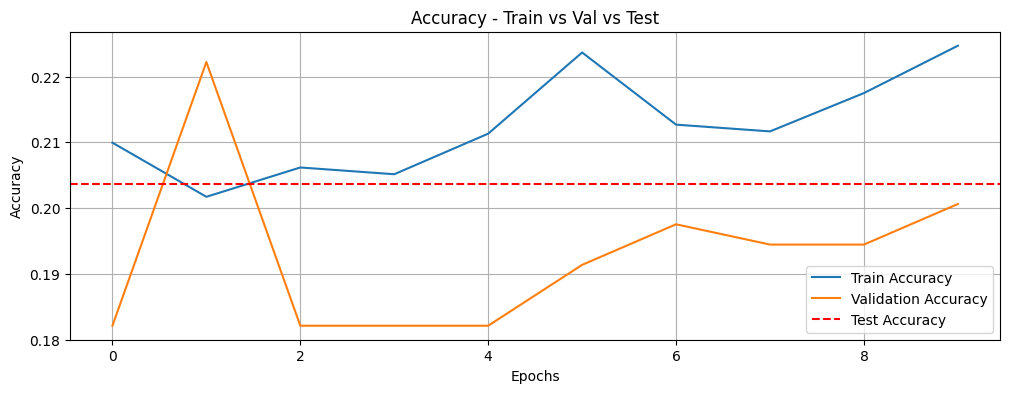

In [79]:
plt.figure(figsize=(12,4))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_test, color='red', linestyle='--', label='Test Accuracy')
plt.title("Accuracy - Train vs Val vs Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 942ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.00      0.00      0.00       163
            im_Koilocytotic       0.20      1.00      0.34       165
             im_Metaplastic       0.00      0.00      0.00       159
               im_Parabasal       0.00      0.00      0.00       157
im_Superficial-Intermediate       0.00      0.00      0.00       166

                   accuracy                           0.20       810
                  macro avg       0.04      0.20      0.07       810
               weighted avg       0.04      0.20      0.07       810



c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

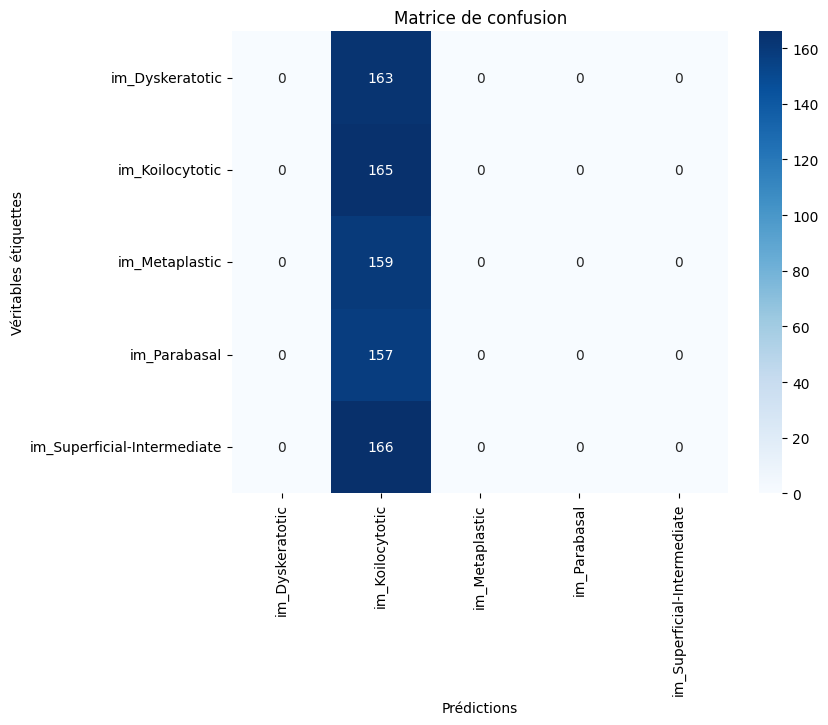

In [80]:
y_pred = model_resnet.predict(X_test_proc)     
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_enc, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))
                    
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()

In [81]:
model_resnet.save('../models/resnet50_ccu.h5')

## EfficientNetB0

In [82]:
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x) 

model_effnet = Model(inputs, outputs)

model_effnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

model_effnet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [83]:
history3 = model_effnet.fit(
    X_train_proc, y_train_enc,
    validation_split=0.1,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 373ms/step - accuracy: 0.2077 - loss: 1.6518 - val_accuracy: 0.2130 - val_loss: 1.6143
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 337ms/step - accuracy: 0.1942 - loss: 1.6442 - val_accuracy: 0.1821 - val_loss: 1.6174
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 354ms/step - accuracy: 0.2065 - loss: 1.6252 - val_accuracy: 0.1821 - val_loss: 1.6171
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 353ms/step - accuracy: 0.2090 - loss: 1.6171 - val_accuracy: 0.2130 - val_loss: 1.6128
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 357ms/step - accuracy: 0.2063 - loss: 1.6202 - val_accuracy: 0.2130 - val_loss: 1.6105
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 359ms/step - accuracy: 0.2048 - loss: 1.6149 - val_accuracy: 0.2593 - val_loss: 1.6094
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 354ms/step - accuracy: 0.1992 - loss: 1.6133 - val_accuracy: 0.1821 - val_loss: 1.6096
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 333ms/step - accuracy: 0.1938 - loss: 1.6140 - val_accu

In [84]:
loss_train, acc_train = model_effnet.evaluate(X_train_proc, y_train_enc, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {acc_train:.2%}")

loss_test, acc_test = model_effnet.evaluate(X_test_proc, y_test_enc, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.2%}")

Train Loss: 1.6092
Train Accuracy: 20.53%
Test Loss: 1.6092
Test Accuracy: 20.49%


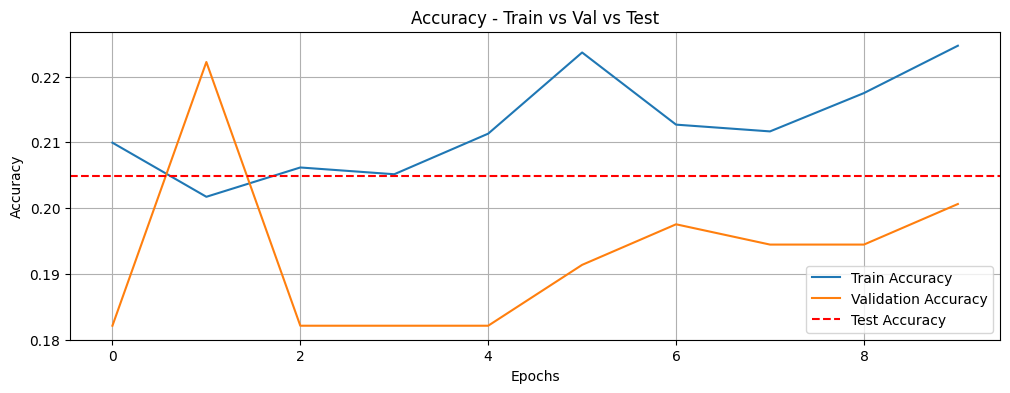

In [85]:
plt.figure(figsize=(12,4))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_test, color='red', linestyle='--', label='Test Accuracy')
plt.title("Accuracy - Train vs Val vs Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 389ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.00      0.00      0.00       163
            im_Koilocytotic       0.00      0.00      0.00       165
             im_Metaplastic       0.00      0.00      0.00       159
               im_Parabasal       0.00      0.00      0.00       157
im_Superficial-Intermediate       0.20      1.00      0.34       166

                   accuracy                           0.20       810
                  macro avg       0.04      0.20      0.07       810
               weighted avg       0.04      0.20      0.07       810



c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tyman\OneDrive\Bureau\sipakmed_ml_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

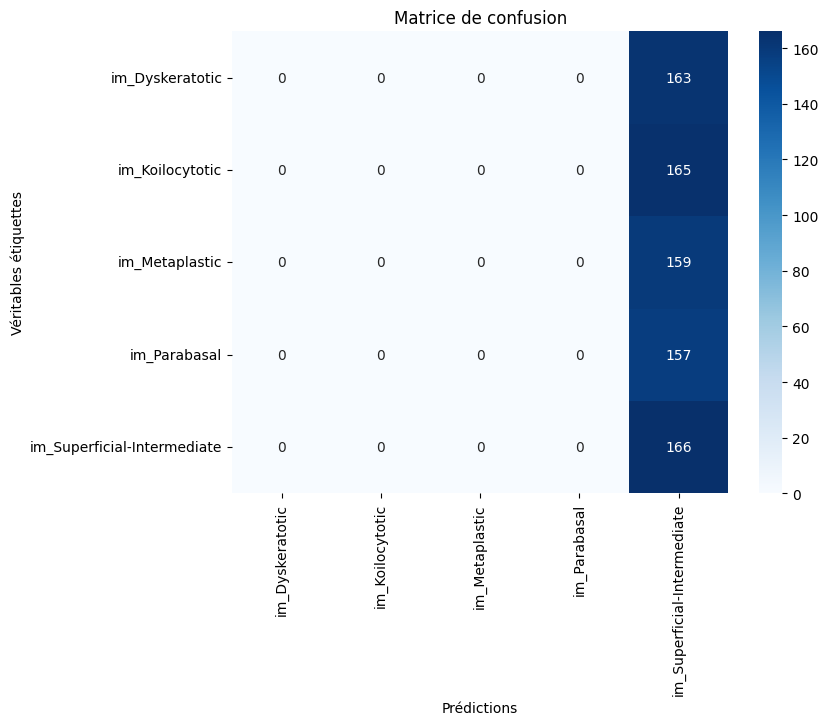

In [86]:
y_pred = model_effnet.predict(X_test_proc)     
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_enc, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()

In [87]:
model_effnet.save('../models/effnetB0_ccu.h5')

## VGG16

In [ ]:
base_vgg = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_vgg.trainable = False  

inputs = Input(shape=(224, 224, 3))
x = base_vgg(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x)

model_vgg = Model(inputs, outputs)

model_vgg.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_vgg.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [89]:
history4 = model_vgg.fit(
    X_train_proc, y_train_enc,
    validation_split=0.1,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.1914 - loss: 1.8784 - val_accuracy: 0.2685 - val_loss: 1.5825
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.2216 - loss: 1.7434 - val_accuracy: 0.3364 - val_loss: 1.5466
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.2311 - loss: 1.7122 - val_accuracy: 0.3426 - val_loss: 1.5228
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.2431 - loss: 1.6672 - val_accuracy: 0.3488 - val_loss: 1.5024
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.2616 - loss: 1.6204 - val_accuracy: 0.3549 - val_loss: 1.4767
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.2660 - loss: 1.5965 - val_accuracy: 0.3611 - val_loss: 1.4629
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.3216 - loss: 1.5613 - val_accuracy: 0.3580 - val_loss: 1.4382
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - accuracy: 0.2995 - loss: 1.5658 - val_accuracy: 0.3611 - v

In [90]:
loss_train, acc_train = model_vgg.evaluate(X_train_proc, y_train_enc, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {acc_train:.2%}")

loss_test, acc_test = model_vgg.evaluate(X_test_proc, y_test_enc, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.2%}")

Train Loss: 1.2690
Train Accuracy: 54.68%
Test Loss: 1.2683
Test Accuracy: 55.19%


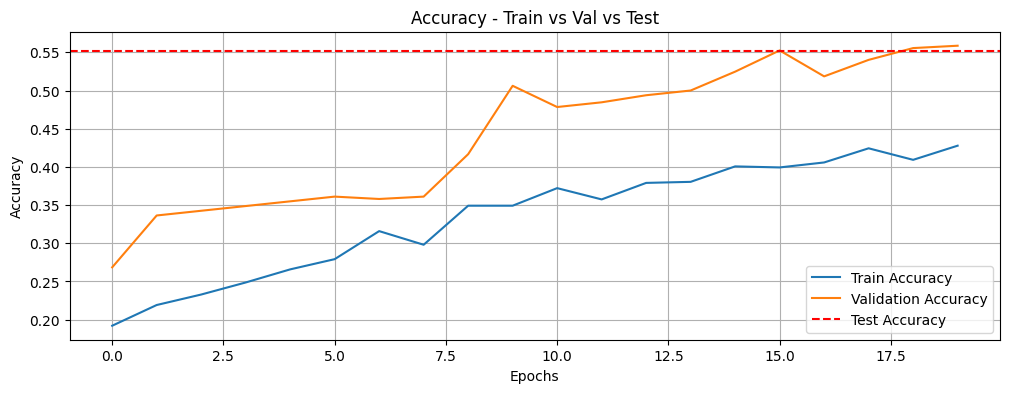

In [91]:
plt.figure(figsize=(12,4))
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_test, color='red', linestyle='--', label='Test Accuracy')
plt.title("Accuracy - Train vs Val vs Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.50      0.54      0.52       163
            im_Koilocytotic       0.88      0.13      0.23       165
             im_Metaplastic       0.45      0.43      0.44       159
               im_Parabasal       0.78      0.70      0.74       157
im_Superficial-Intermediate       0.50      0.95      0.66       166

                   accuracy                           0.55       810
                  macro avg       0.62      0.55      0.52       810
               weighted avg       0.62      0.55      0.52       810



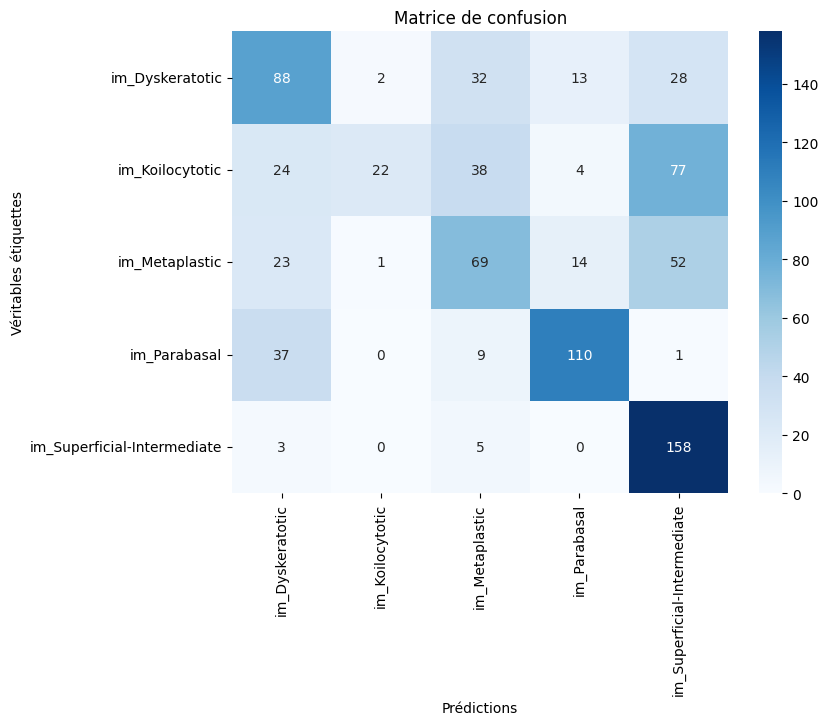

In [92]:
y_pred = model_vgg.predict(X_test_proc)     
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_enc, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()

In [93]:
model_vgg.save('../models/vgg16_ccu.h5')

## DenseNet

In [ ]:
base_densenet = DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_densenet.trainable = False 

inputs = Input(shape=(224, 224, 3))
x = base_densenet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x)

model_densenet = Model(inputs, outputs)

model_densenet.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

In [95]:
history5 = model_densenet.fit(
    X_train_proc, y_train_enc,
    validation_split=0.1,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.2604 - loss: 1.8353 - val_accuracy: 0.5648 - val_loss: 1.2097
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 985ms/step - accuracy: 0.3896 - loss: 1.4075 - val_accuracy: 0.6821 - val_loss: 0.9953
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 995ms/step - accuracy: 0.5082 - loss: 1.2015 - val_accuracy: 0.7346 - val_loss: 0.8711
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 988ms/step - accuracy: 0.5681 - loss: 1.0675 - val_accuracy: 0.7963 - val_loss: 0.7611
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6002 - loss: 1.0043 - val_accuracy: 0.8148 - val_loss: 0.6805
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 994ms/step - accuracy: 0.6441 - loss: 0.9267 - val_accuracy: 0.8117 - val_loss: 0.6204
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 995ms/step - accuracy: 0.6717 - loss: 0.8636 - val_accuracy: 0.8302 - val_loss: 0.5799
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 986ms/step - accuracy: 0.6705 - loss: 0.8542 - val_accuracy:

In [96]:
loss_train, acc_train = model_densenet.evaluate(X_train_proc, y_train_enc, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {acc_train:.2%}")

loss_test, acc_test = model_densenet.evaluate(X_test_proc, y_test_enc, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.2%}")

Train Loss: 0.3854
Train Accuracy: 87.90%
Test Loss: 0.4206
Test Accuracy: 85.93%


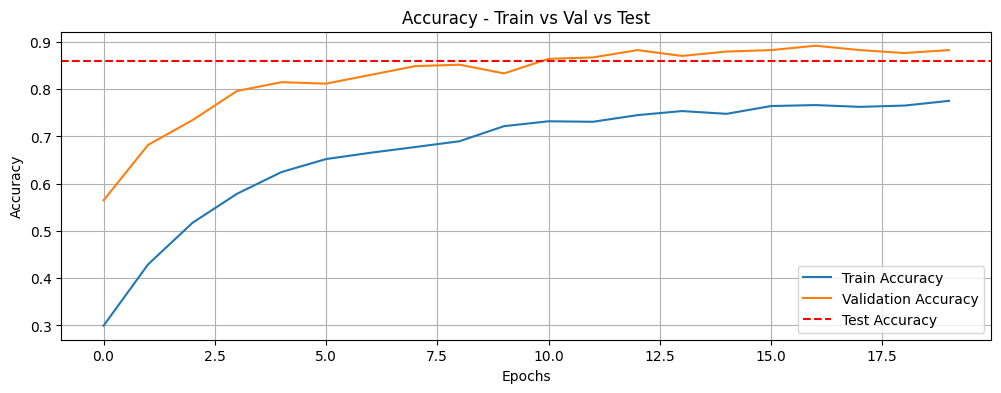

In [97]:
plt.figure(figsize=(12,4))
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_test, color='red', linestyle='--', label='Test Accuracy')
plt.title("Accuracy - Train vs Val vs Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 942ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.88      0.92      0.90       163
            im_Koilocytotic       0.85      0.71      0.77       165
             im_Metaplastic       0.78      0.82      0.80       159
               im_Parabasal       0.88      0.88      0.88       157
im_Superficial-Intermediate       0.90      0.97      0.94       166

                   accuracy                           0.86       810
                  macro avg       0.86      0.86      0.86       810
               weighted avg       0.86      0.86      0.86       810



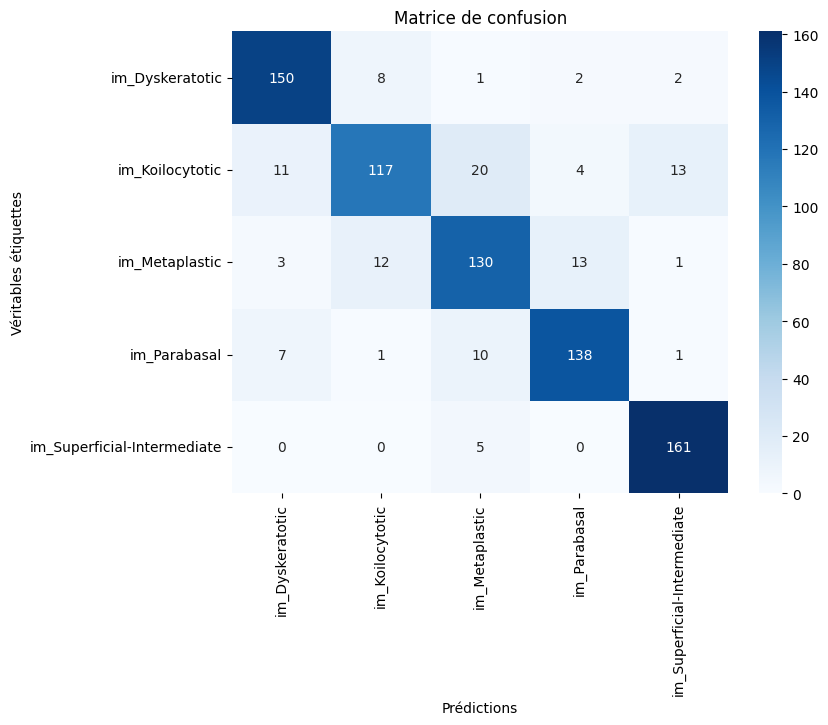

In [98]:
y_pred = model_densenet.predict(X_test_proc)     
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_enc, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()

In [99]:
model_densenet.save('../models/densenet_ccu.h5')

# Summary

Parmi les modèles testés, DenseNet s’est révélé être le plus performant. Il affiche les meilleures valeurs de précision (accuracy) sur les données de test tout en maintenant une généralisation stable, ce qui indique qu’il n’a pas surappris (overfitting) les données d’entraînement. Cette robustesse fait de DenseNet le modèle le plus fiable pour la classification des cellules dans notre contexte.

In [100]:
def plot_model_history(histories, model_names):
    """
    histories : liste des objets `History` retournés par model.fit()
    model_names : liste des noms des modèles correspondants
    """
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} - Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} - Val')
    plt.title('Évolution de l\'accuracy')
    plt.xlabel('Époques')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} - Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} - Val')
    plt.title('Évolution de la perte (loss)')
    plt.xlabel('Époques')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


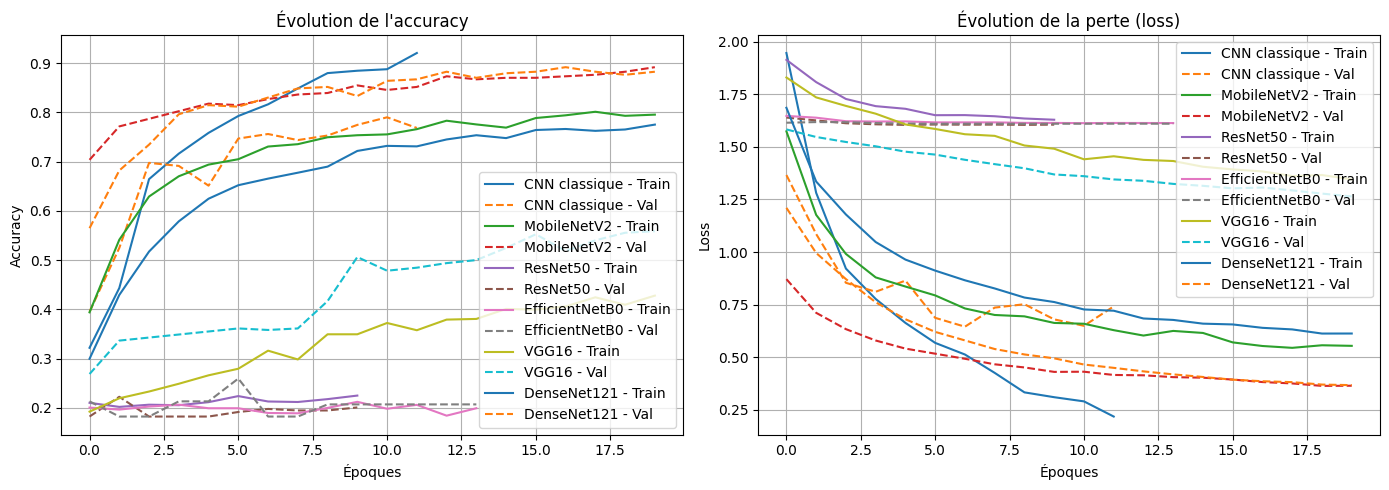

In [101]:
histories = [history01, history1, history2, history3, history4, history5]
model_names = ['CNN classique','MobileNetV2', 'ResNet50', 'EfficientNetB0', 'VGG16', 'DenseNet121']

plot_model_history(histories, model_names)


# BEST MODEL : DENSE NET

In [24]:
history_of_best = model_densenet.fit(
    X_train_proc, y_train_enc,
    validation_split=0.1,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.2091 - loss: 2.0488 - val_accuracy: 0.5062 - val_loss: 1.3281
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 992ms/step - accuracy: 0.3360 - loss: 1.5332 - val_accuracy: 0.6667 - val_loss: 1.1278
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 995ms/step - accuracy: 0.4471 - loss: 1.3569 - val_accuracy: 0.7346 - val_loss: 0.9960
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.4896 - loss: 1.2536 - val_accuracy: 0.7562 - val_loss: 0.9004
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5316 - loss: 1.1402 - val_accuracy: 0.7747 - val_loss: 0.8304
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6032 - loss: 1.0577 - val_accuracy: 0.7870 - val_loss: 0.7615
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6052 - loss: 1.0135 - val_accuracy: 0.7963 - val_loss: 0.7117
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6173 - loss: 0.9717 - val_accuracy: 0.8

In [25]:
loss_train, acc_train = model_densenet.evaluate(X_train_proc, y_train_enc, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {acc_train:.2%}")

loss_test, acc_test = model_densenet.evaluate(X_test_proc, y_test_enc, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.2%}")

Train Loss: 0.2933
Train Accuracy: 90.86%
Test Loss: 0.3678
Test Accuracy: 87.41%


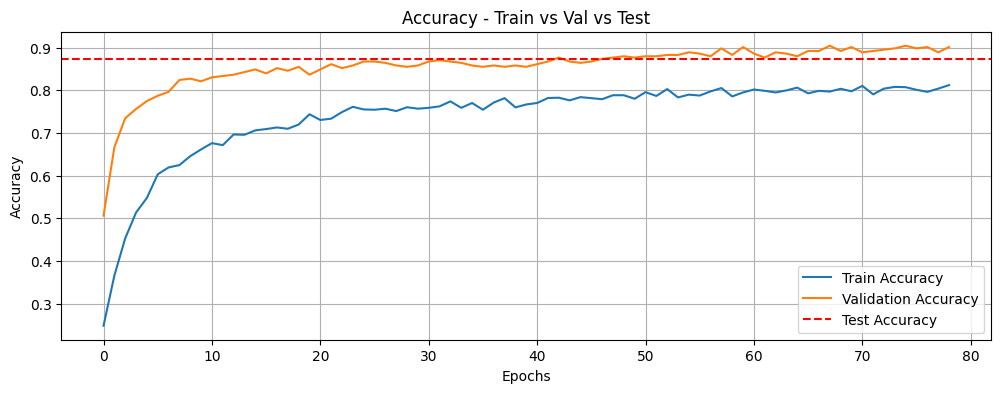

In [26]:
plt.figure(figsize=(12,4))
plt.plot(history_of_best.history['accuracy'], label='Train Accuracy')
plt.plot(history_of_best.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_test, color='red', linestyle='--', label='Test Accuracy')
plt.title("Accuracy - Train vs Val vs Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step 
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.85      0.96      0.90       163
            im_Koilocytotic       0.84      0.72      0.78       165
             im_Metaplastic       0.84      0.81      0.82       159
               im_Parabasal       0.93      0.89      0.91       157
im_Superficial-Intermediate       0.91      0.99      0.95       166

                   accuracy                           0.87       810
                  macro avg       0.87      0.87      0.87       810
               weighted avg       0.87      0.87      0.87       810



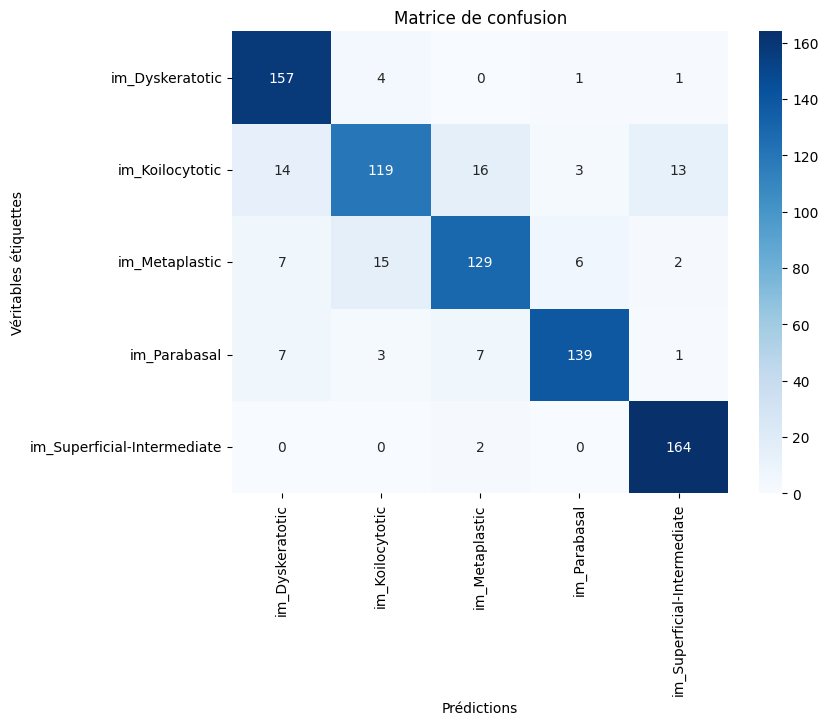

In [28]:
y_pred = model_densenet.predict(X_test_proc)     
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_enc, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()

In [27]:
model_densenet.save('../models/densenet_ccu.h5')